# Idealized Qradratic Model

In [1]:
from pathlib import Path
EXP_PATH = Path()
print("Working Directory:", str(EXP_PATH))
SRC_PATH = Path("../") / "src"
print("Source Code Path:", str(SRC_PATH))
import sys
sys.path.insert(0, str(SRC_PATH))

Working Directory: .
Source Code Path: ../src


In [2]:
from utils.problems import IdealizedQuadraticInverseProblem
import numpy as np


sip = IdealizedQuadraticInverseProblem(
    Lx=100.0,
    Ly=50.0,
    nx=101,
    ny=51,
    cmin=-1.0,
    cmax=1.0,
    mt=np.load("mt.npy"),
    window_config={
        "left": 15,
        "right": 15,
        "up": 15,
        "down": 15,
        "ex": 3.0,
        "ll": 1.5,
    },
    prior_config={"name": "bilaplacian-without-bc", "sigma2": 400.0, "rho": 2.5},
    hessian_config={
        "lr_rank": 10,
        "lr_weight": 1.0,
        "pdo_weight": 0.8,
        "depth_factor": "d2",
    },
    plot_config={
        "rcParams": {
            "image.cmap": "bwr",
        },
        "x_size": [7, 3.5],
        "f_size": [2.25, 2],
    },
    label="idealized",
    path=EXP_PATH,
)
H = sip.misfit_hess(sip.mt)

Bilaplacian prior: delta = 1.5958e-02, gamma = 1.2467e-02


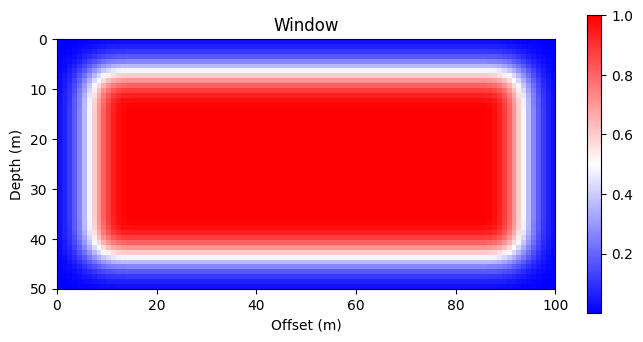

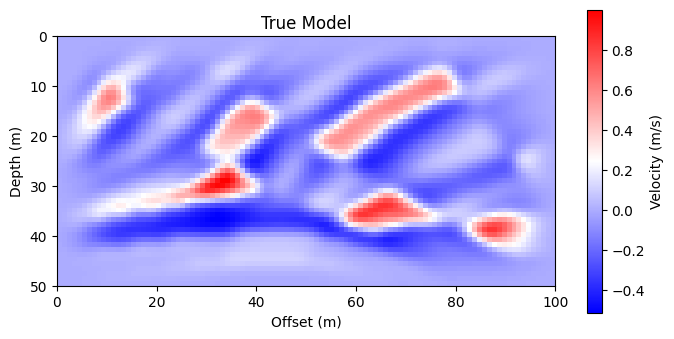

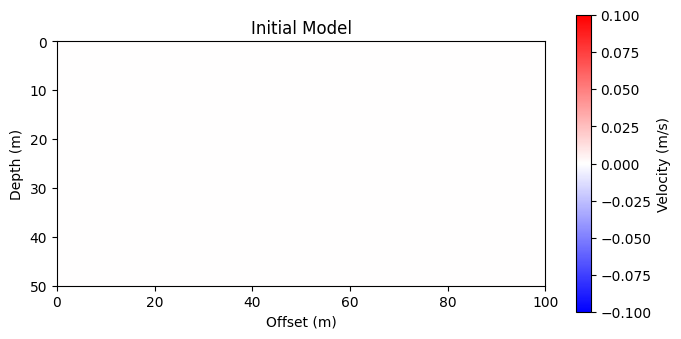

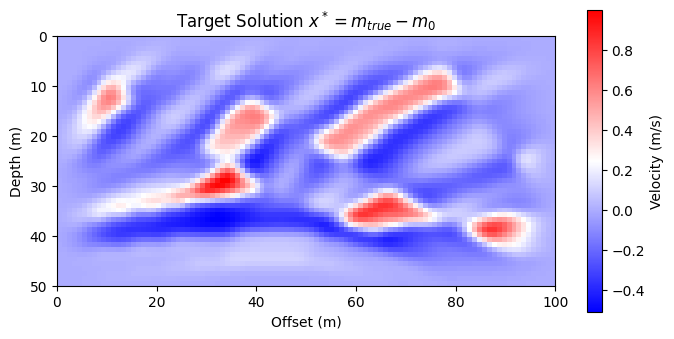

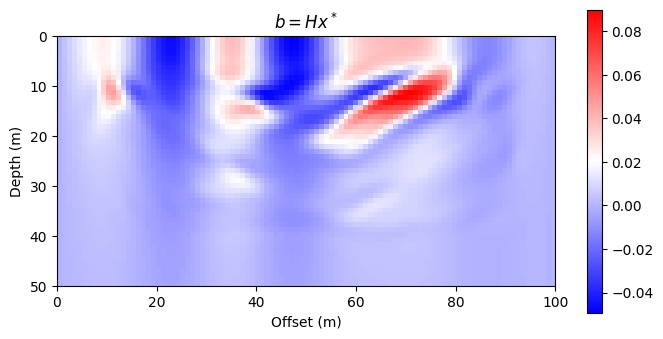

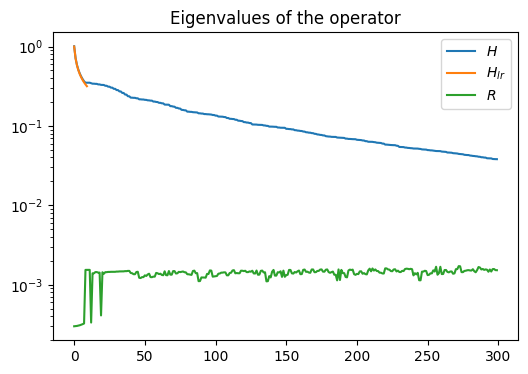

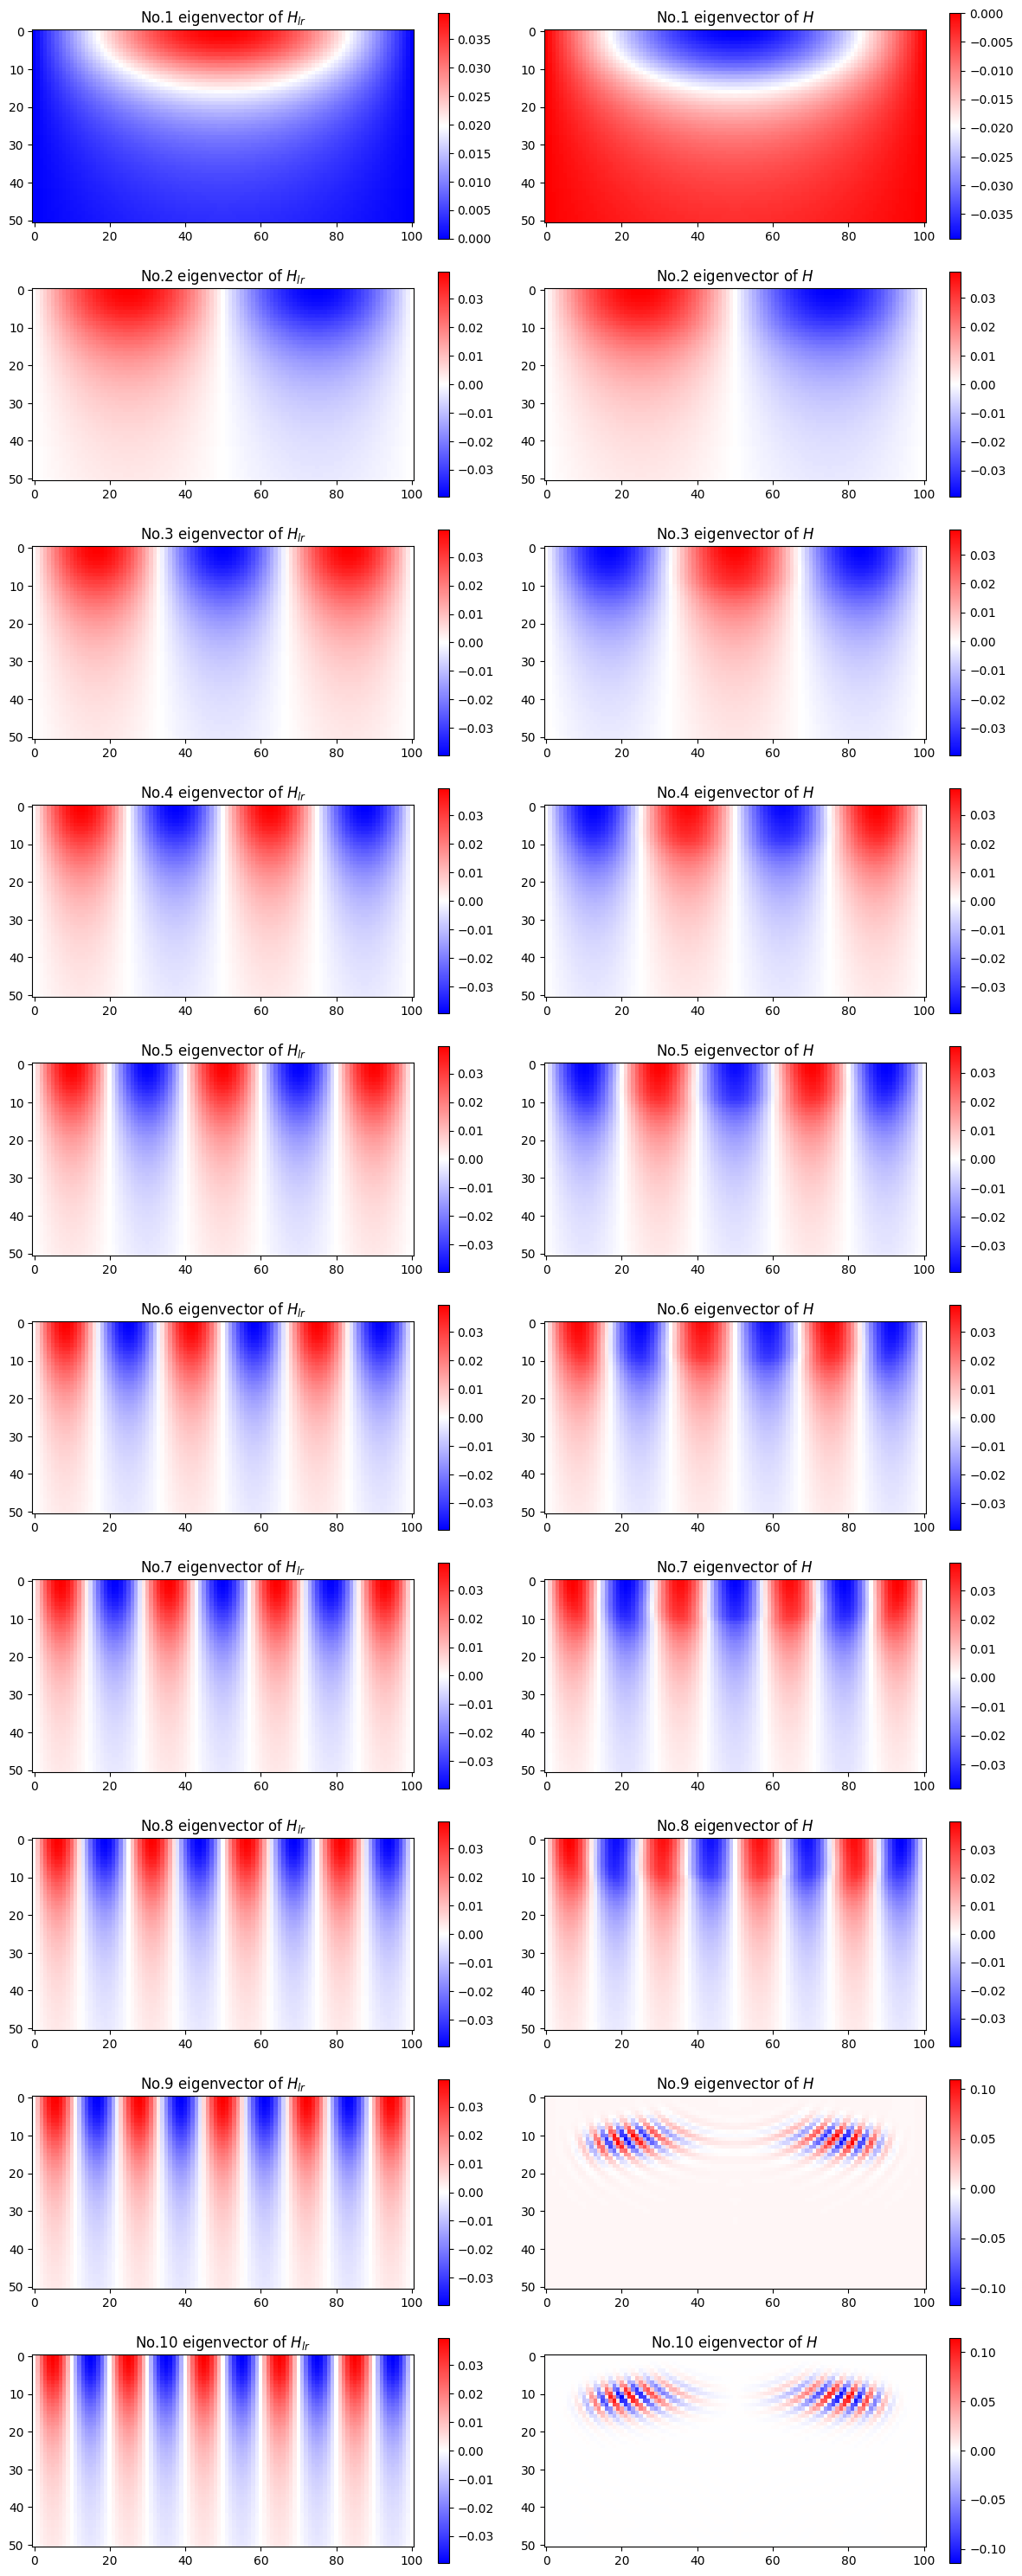

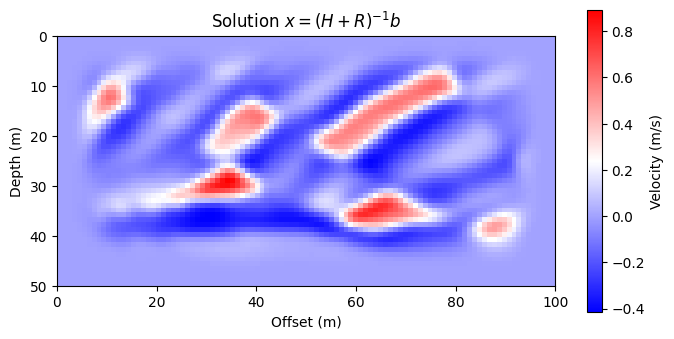

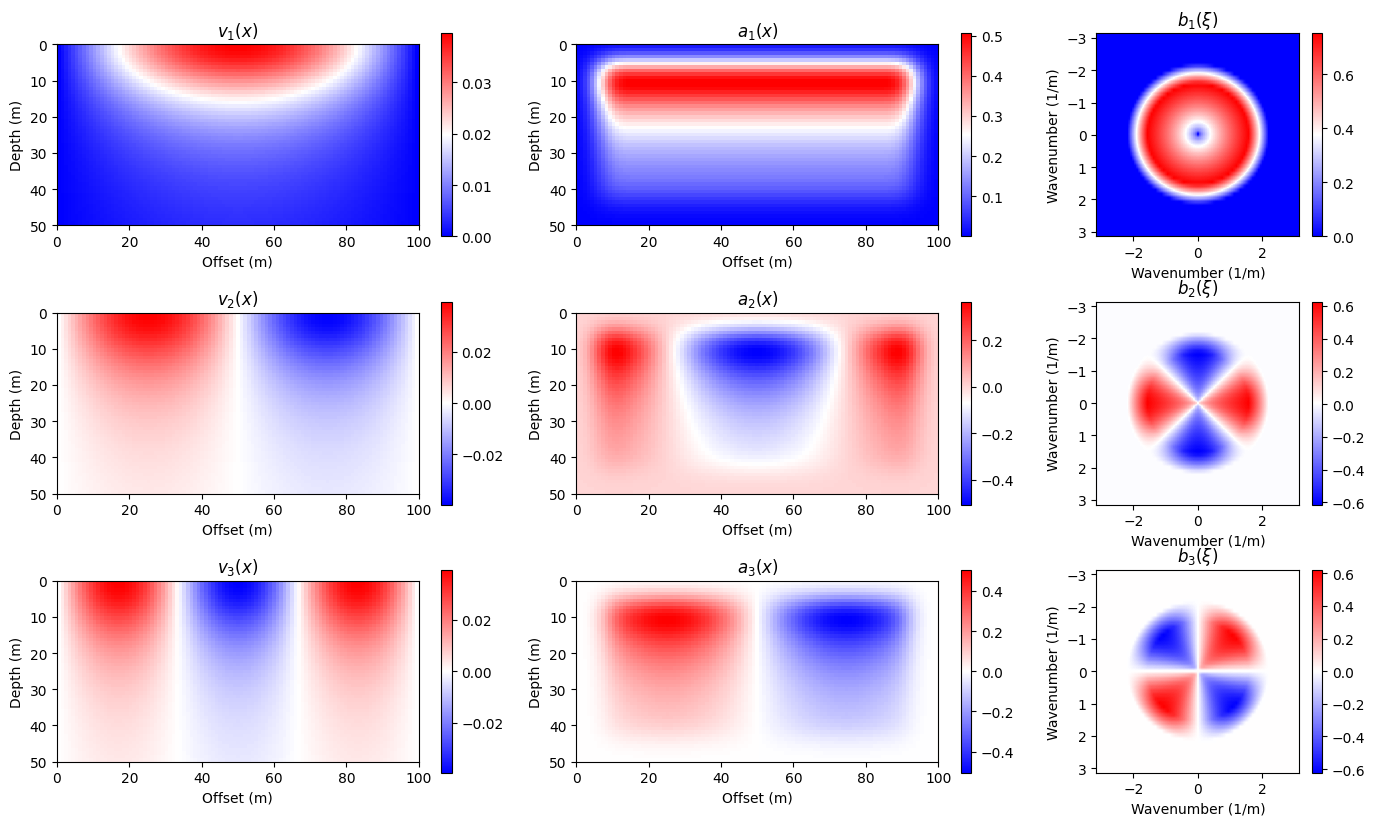

In [3]:
sip.show()

## Hessian approximations

### The PSF Method

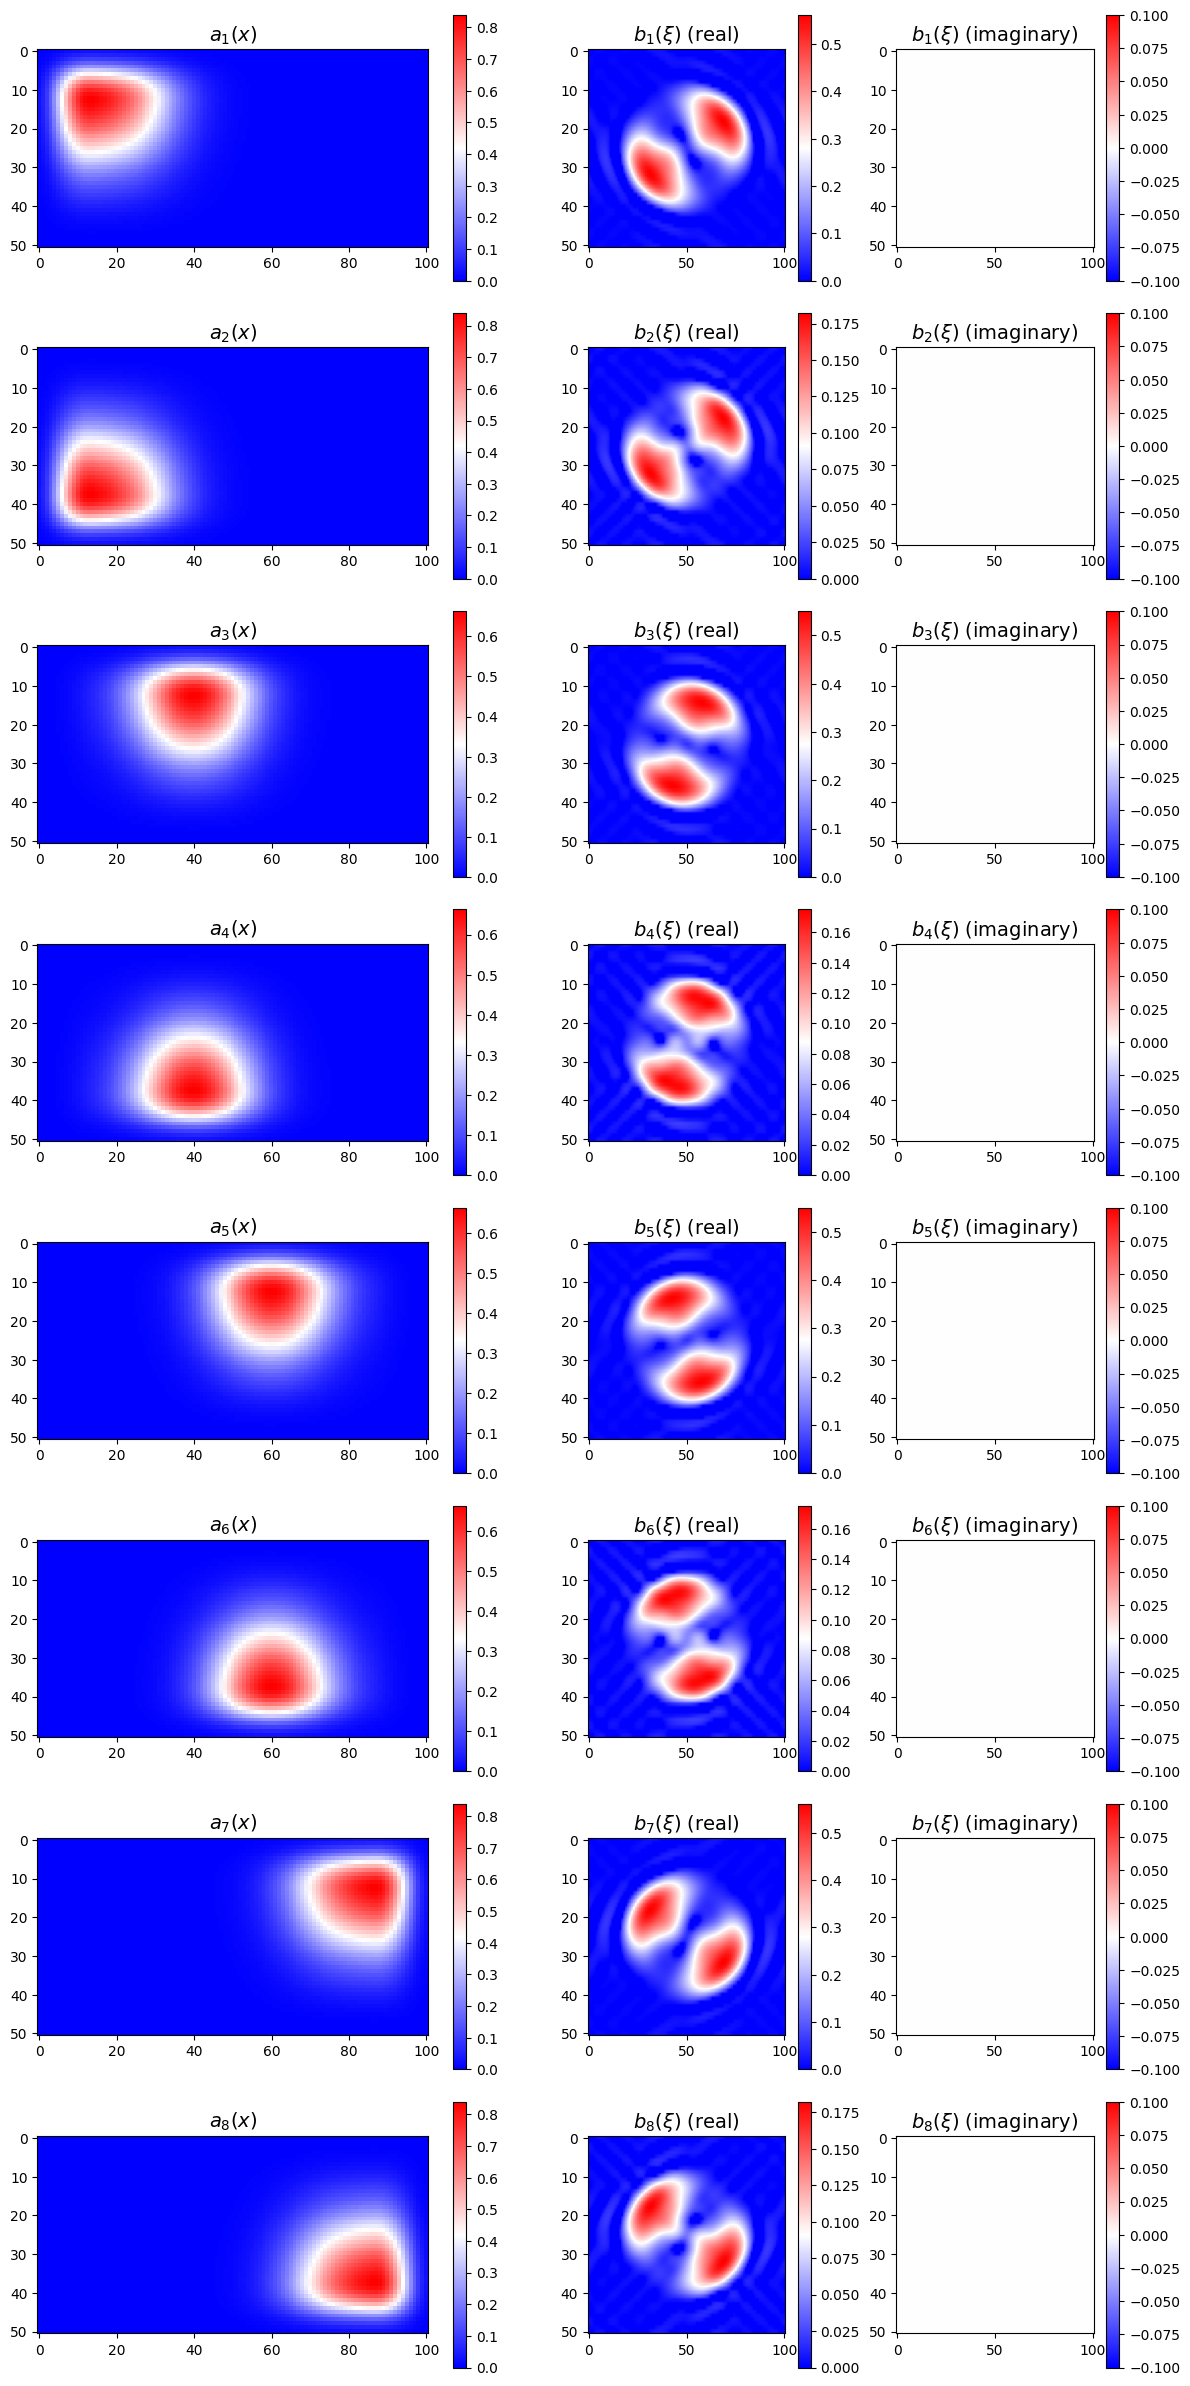

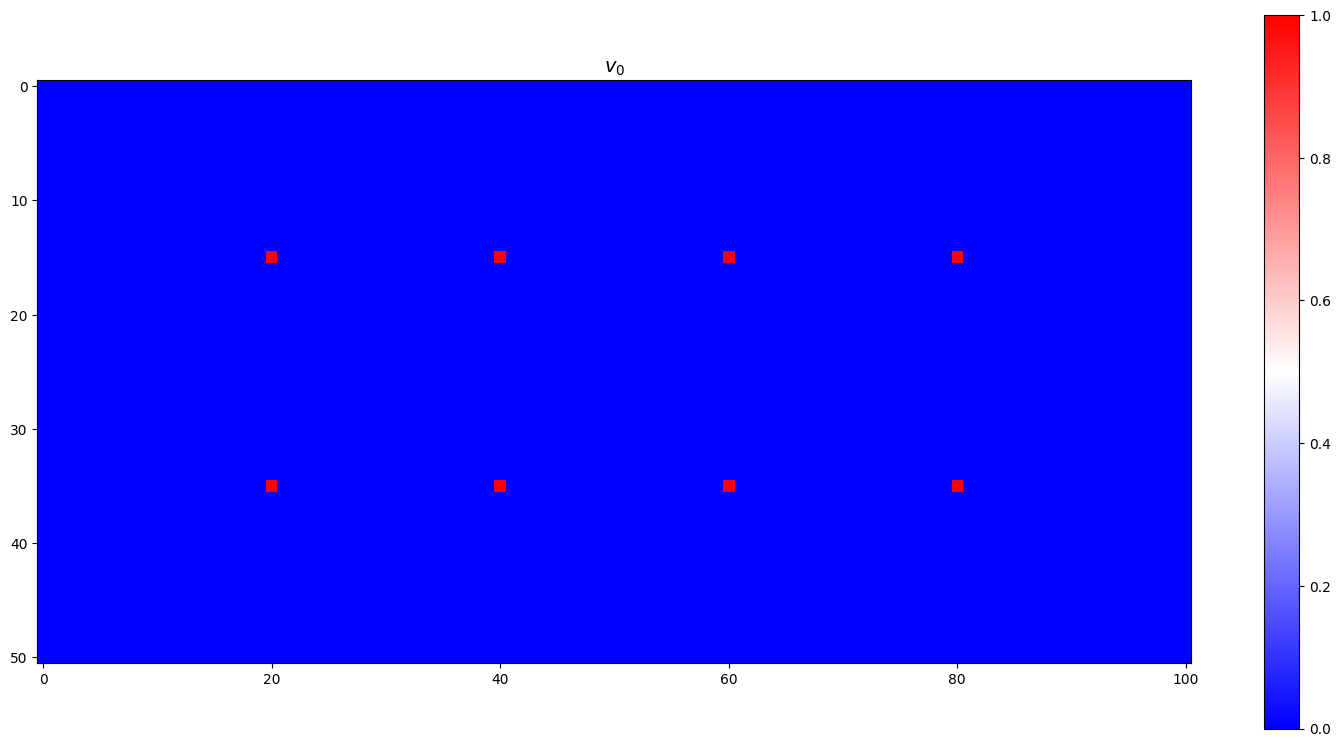

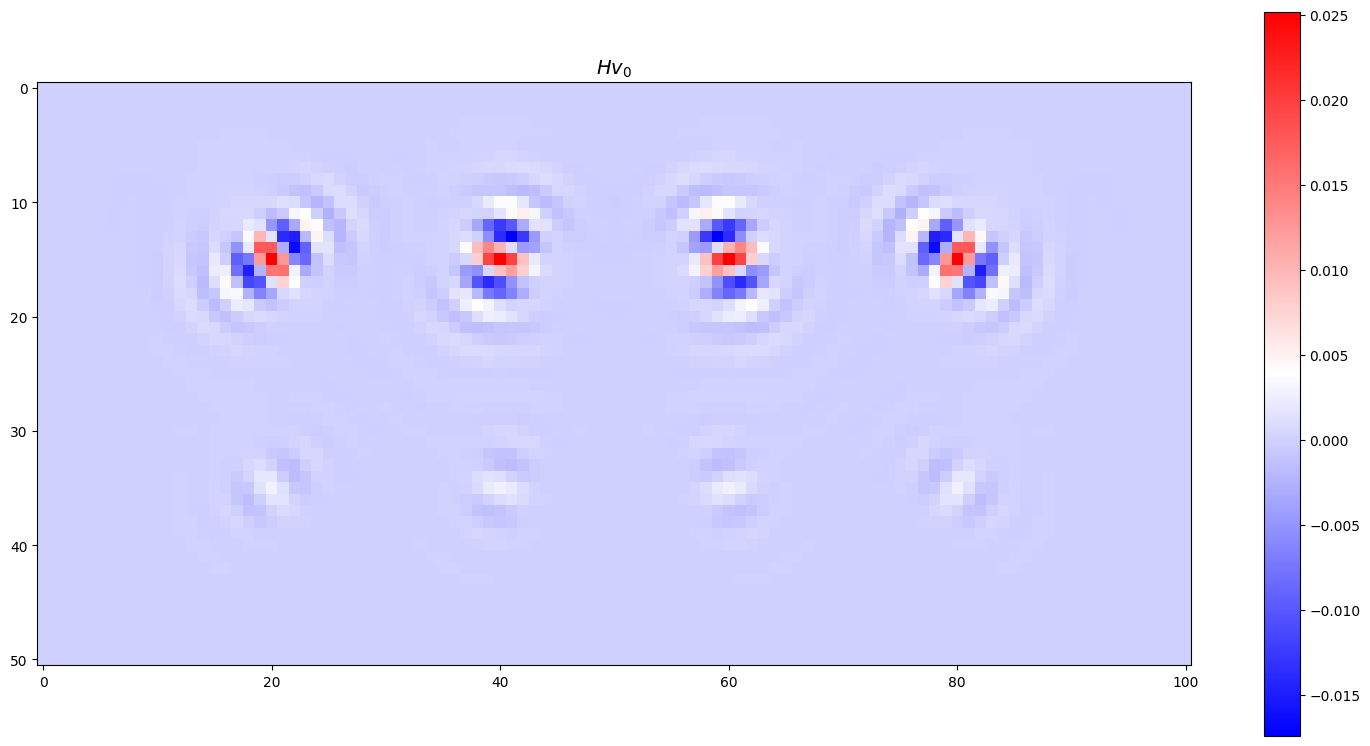

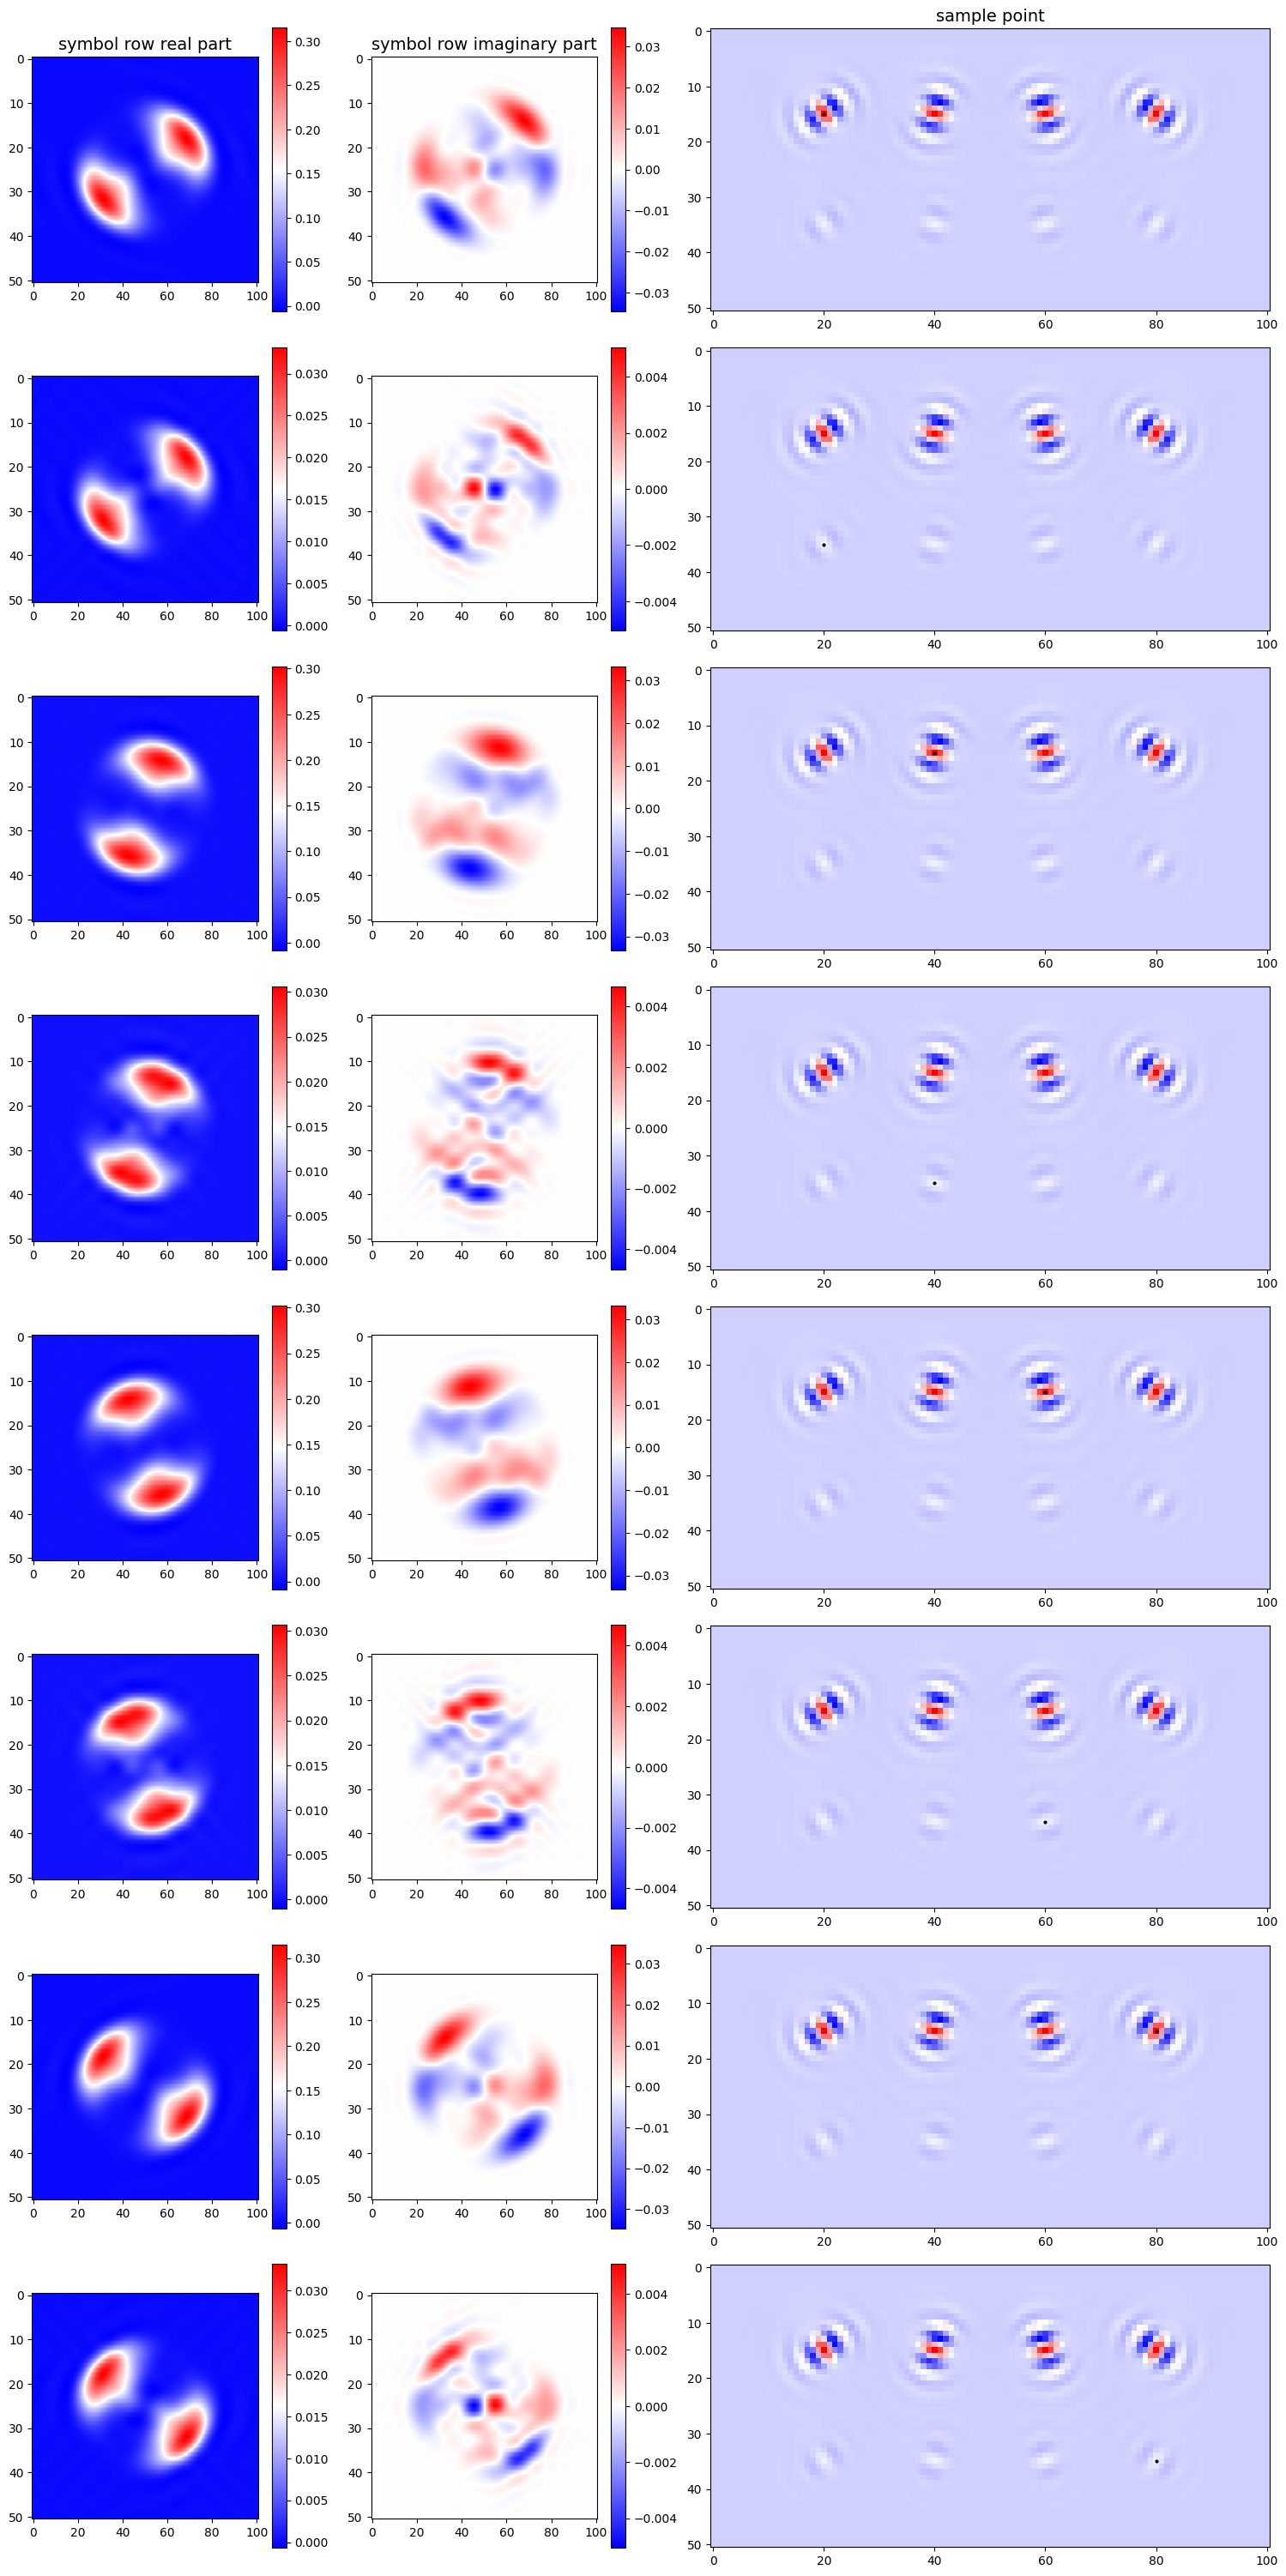

In [4]:
from lrs_psido.approximators import PsfApproximator

psf_settings = {
    "filter_sigma": 4.0,
    "matvec_plan": [
        {
            "sampling": {
                "method": "equispace",
                "steps": [20, 20],
                "anchor": [20, 15],
                "constraint": {"x": [15, 85]},
                "smoothness": 0.4,
            }
        }
    ],
    "smooth": False,
    "real_only": True,
    "sqrt": True,
}
psf_approximator = PsfApproximator(
    sip.n, log_dir=EXP_PATH / "psf", window=sip.window, show_proc=True, **psf_settings
)
psf_sqrtH = psf_approximator.approximate_sqrt(H)

### The PDO Method

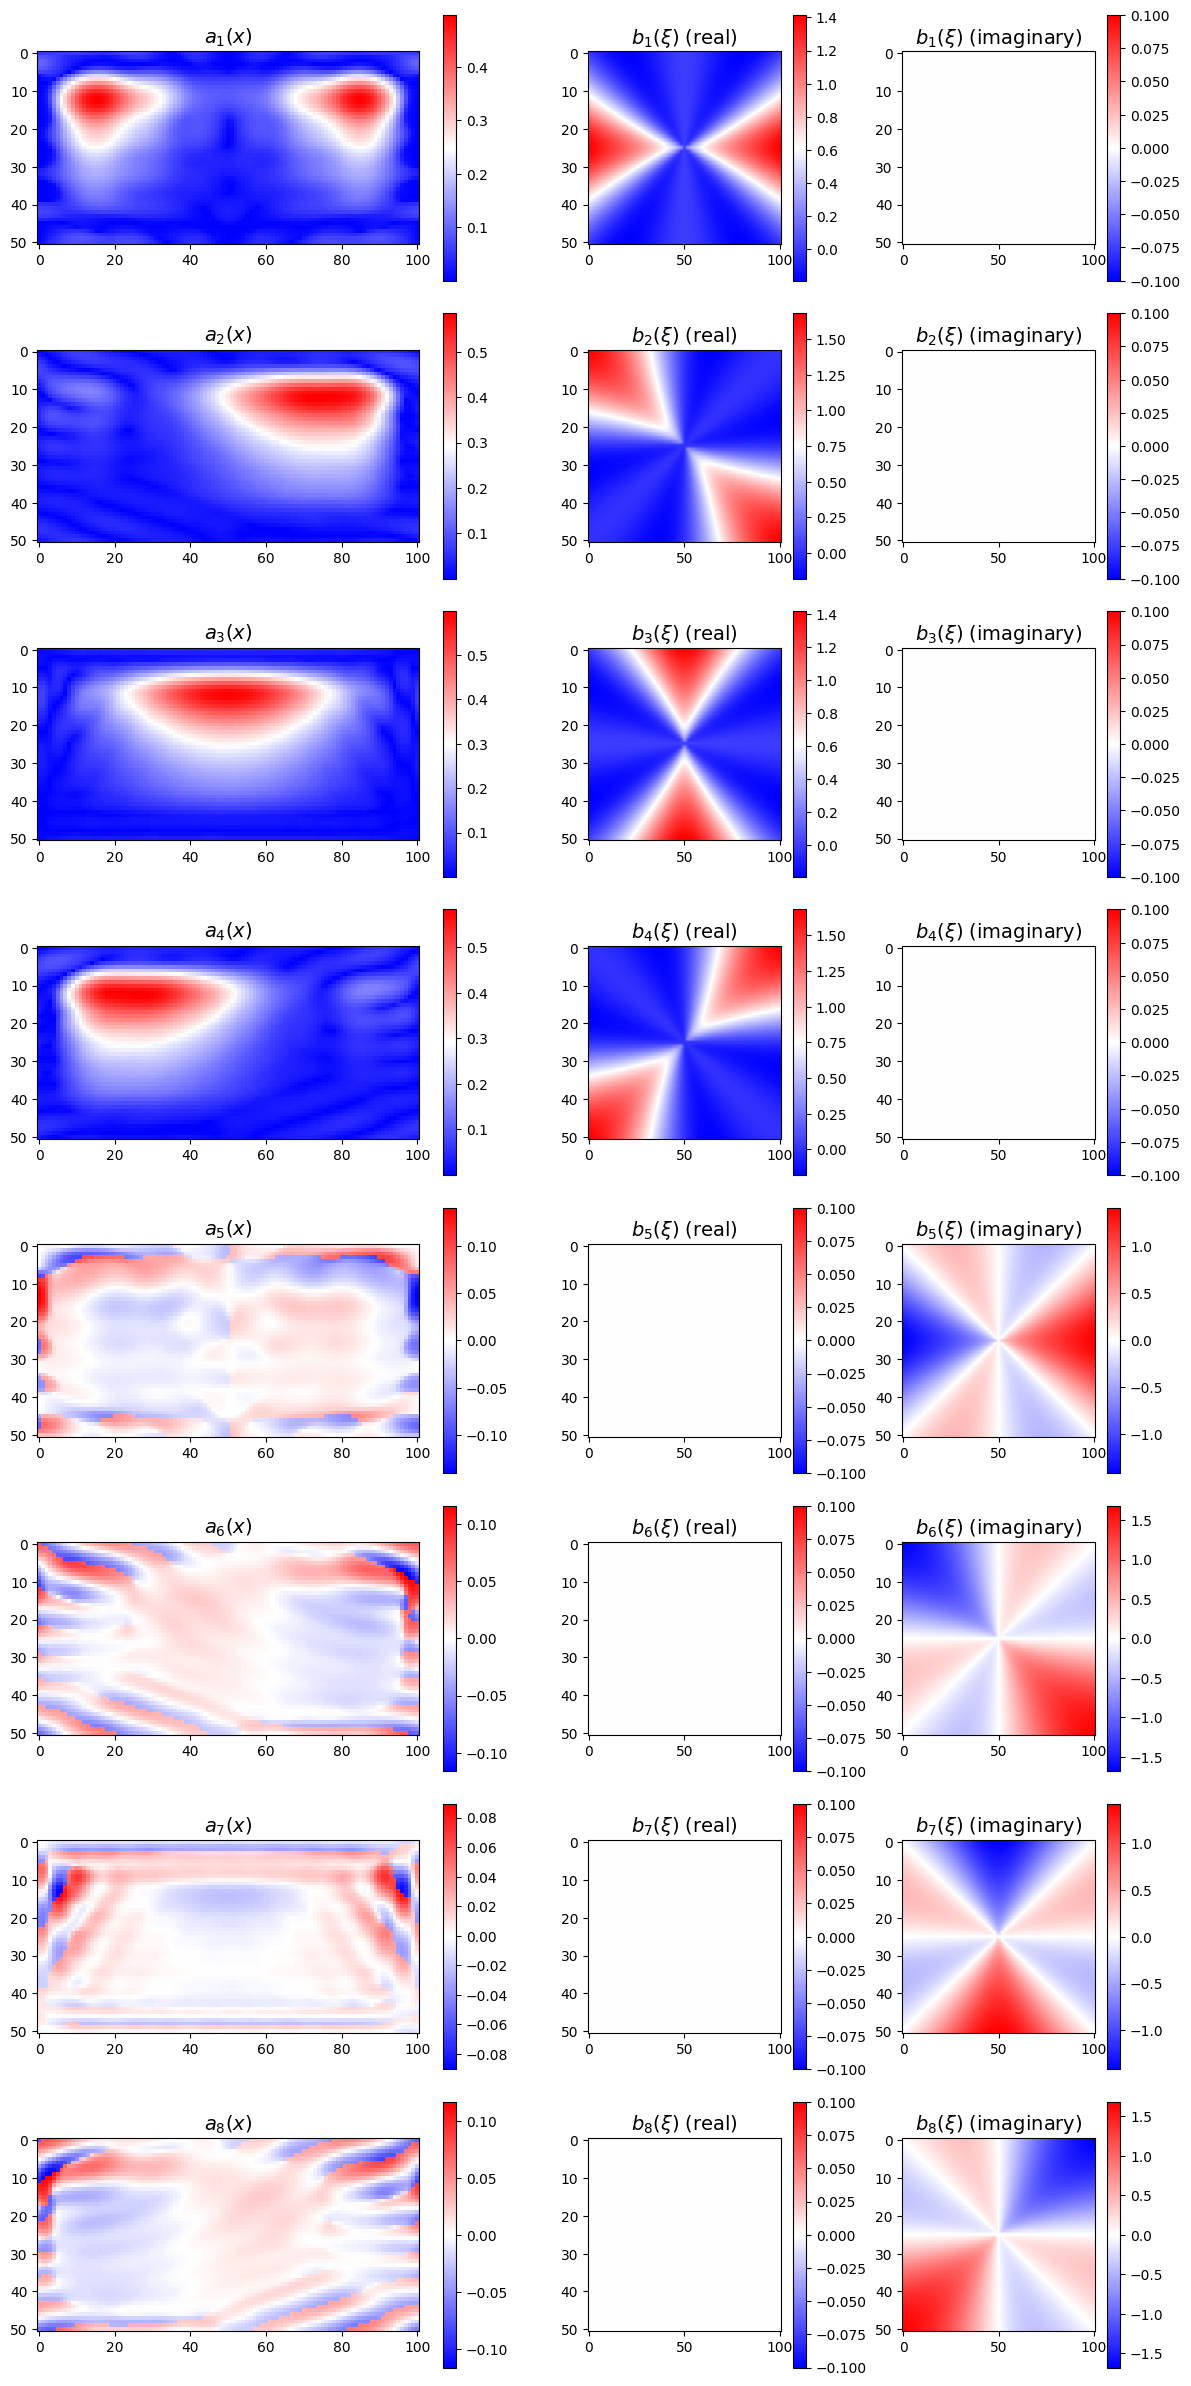

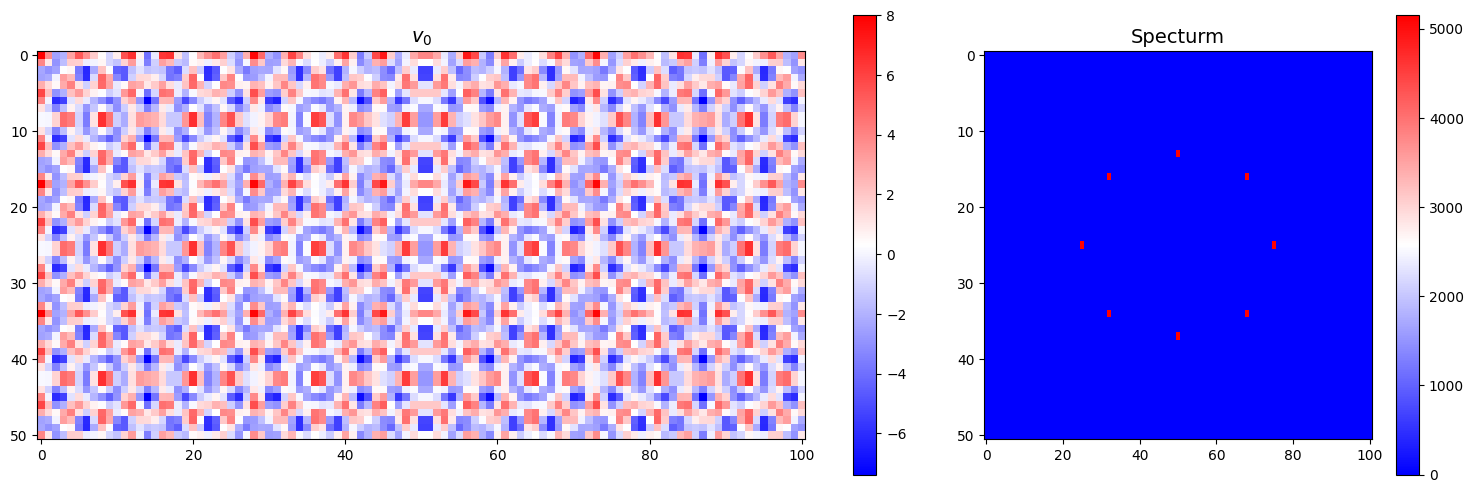

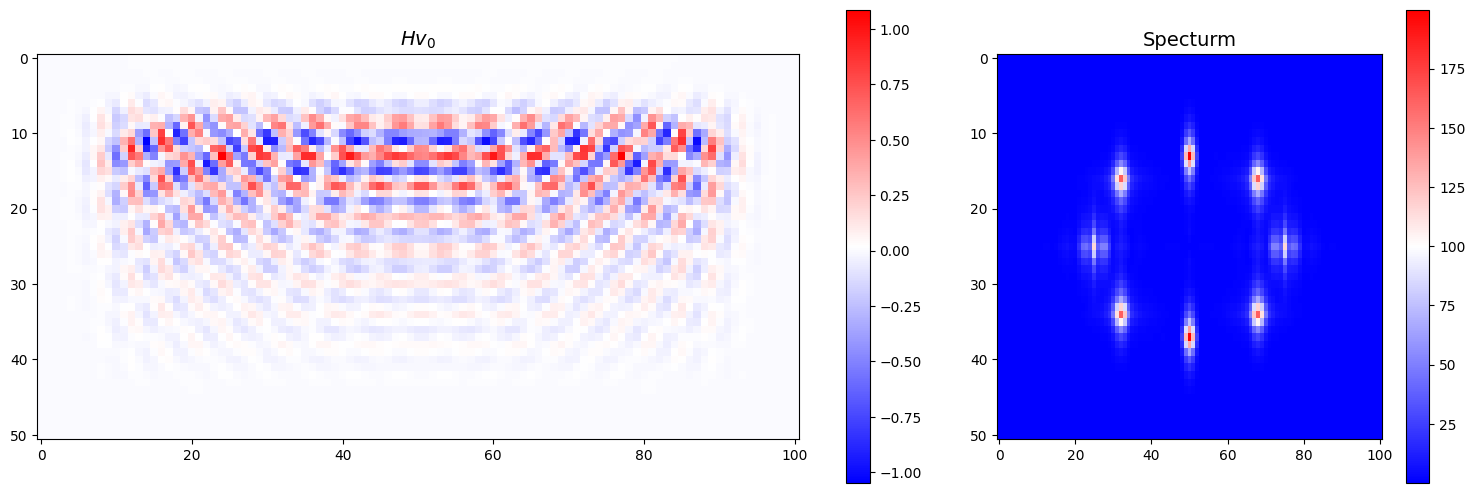

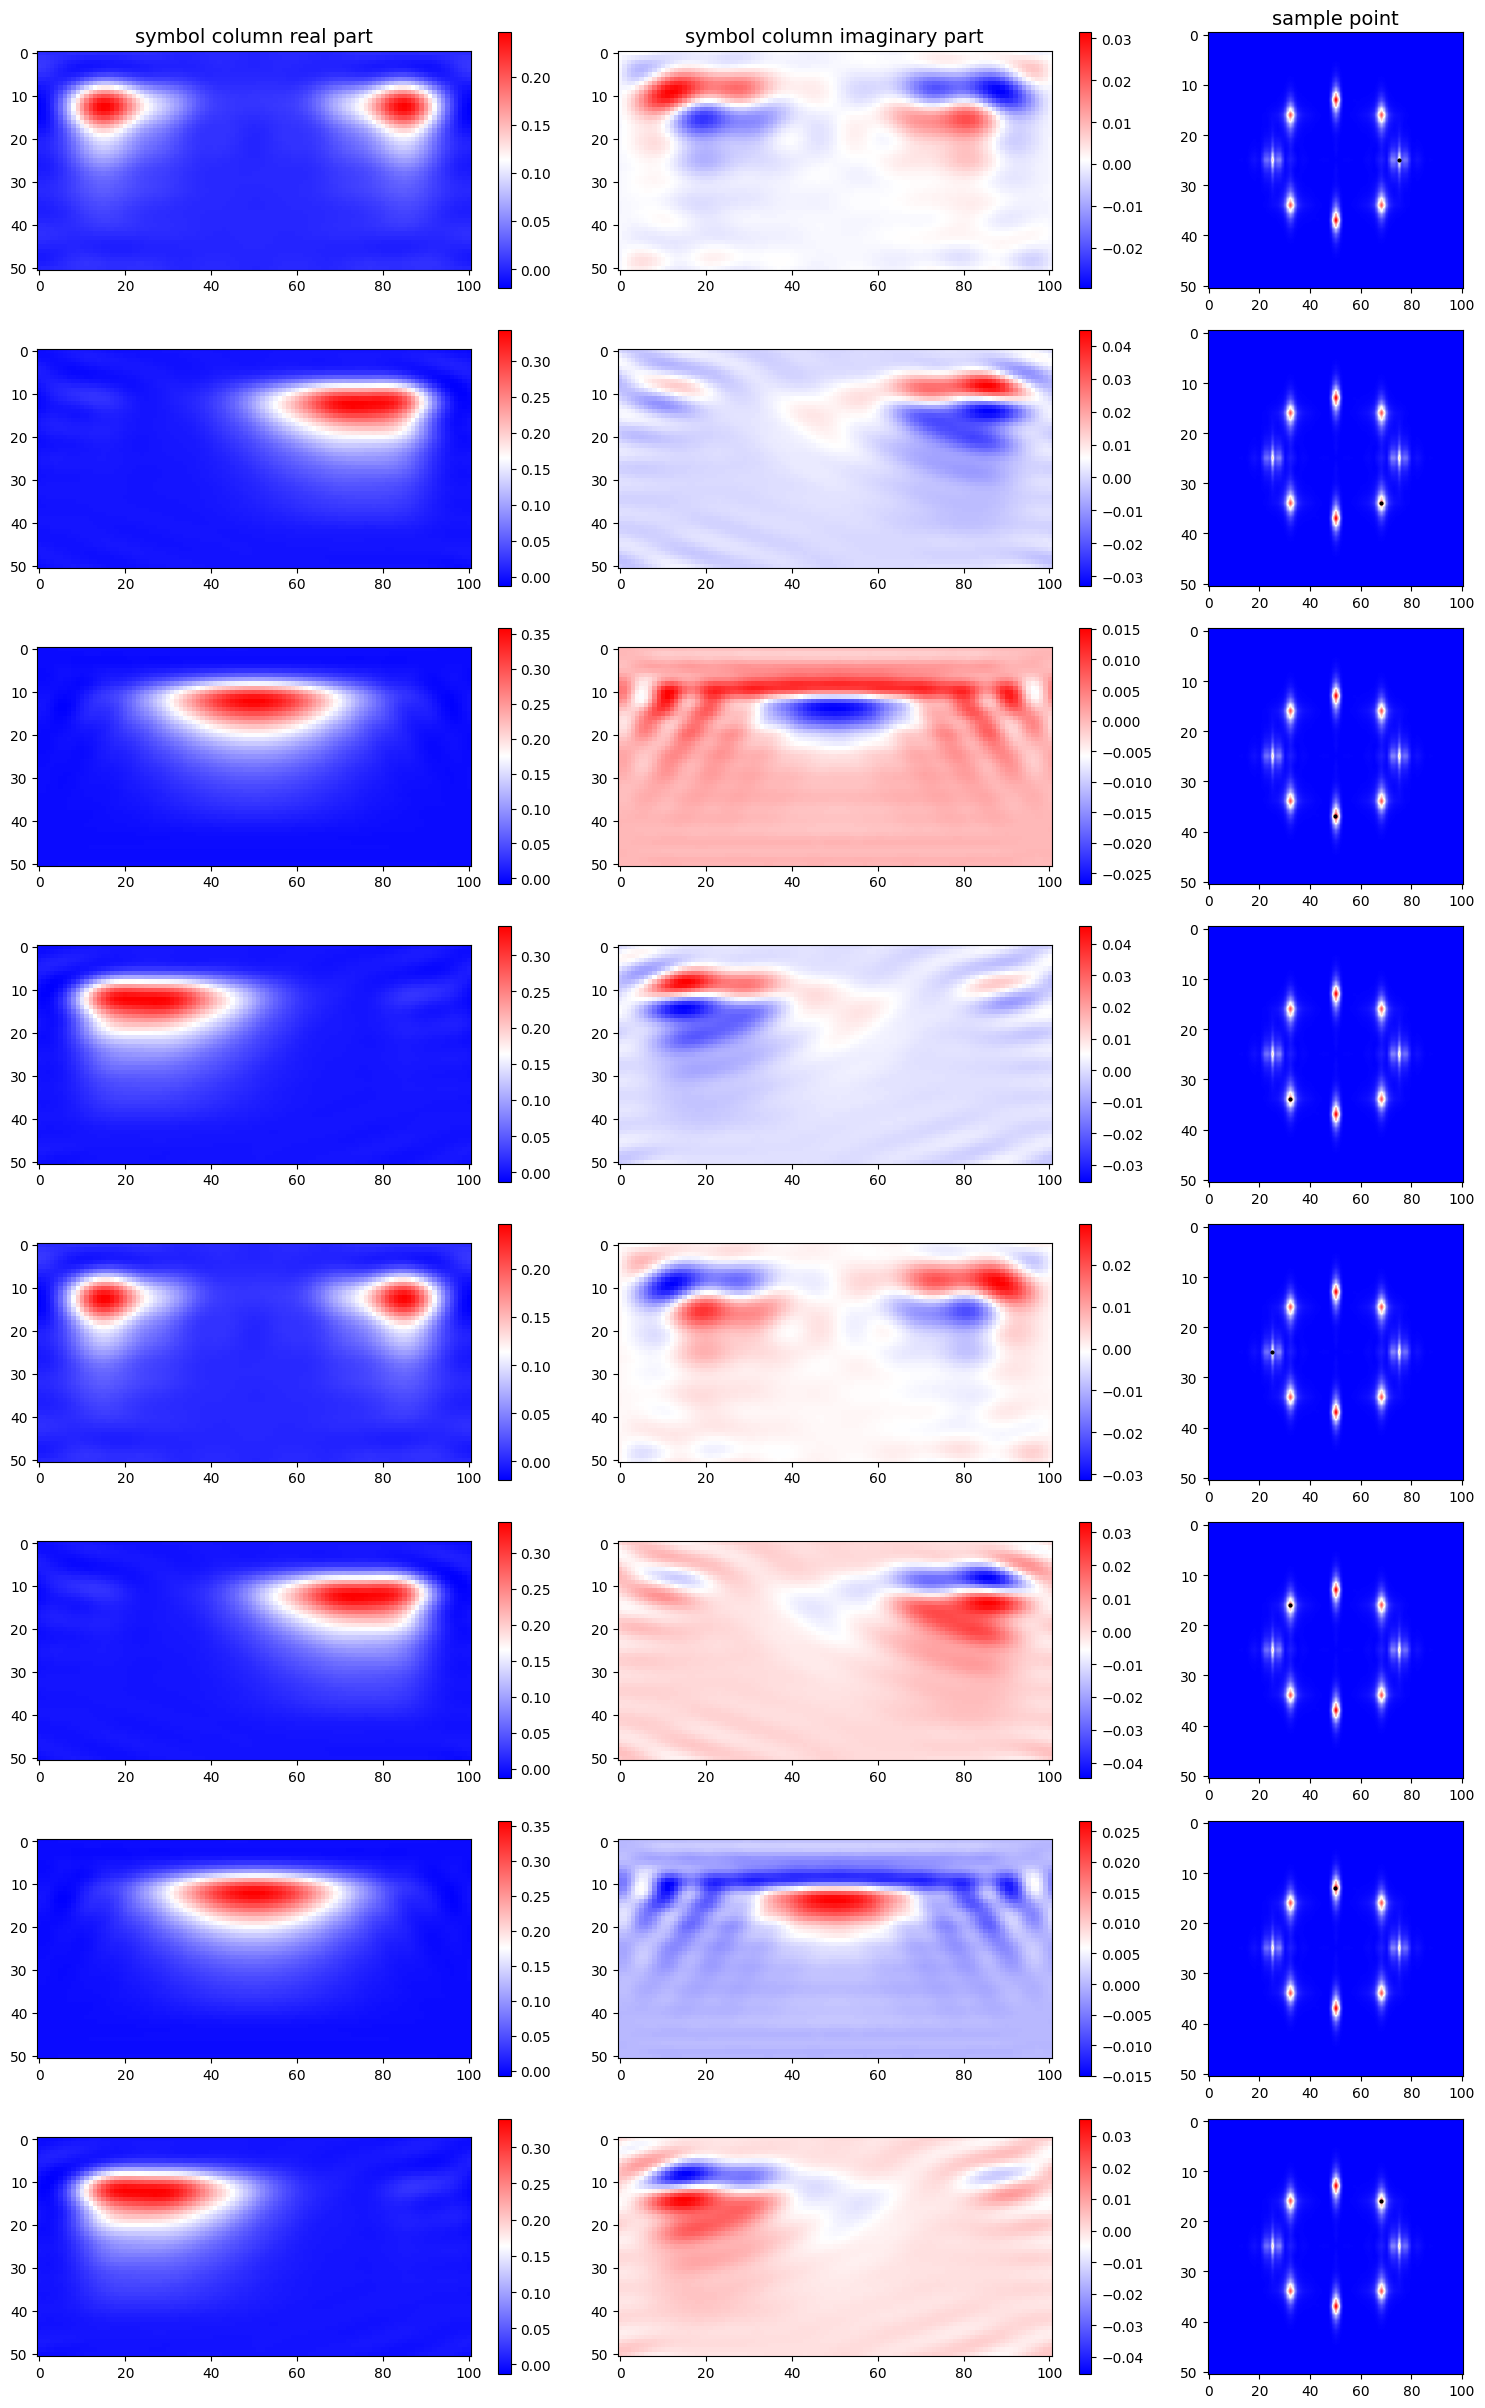

In [5]:
from lrs_psido.approximators import PdoApproximator

pdo_settings = {
    "filter_sigma": 4.0,
    "matvec_plan": [
        {
            "sampling": {"method": "circle", "l2_ratio": 0.5, "num_angles": 8},
            "spliting": {
                "method": "ellipse",
                "sigmas": [
                    [8, 6],
                    [8, 8],
                    [12, 12],
                    [8, 8],
                    [8, 6],
                    [8, 8],
                    [12, 12],
                    [8, 8],
                ],
            },
        }
    ],
    "smooth": False,
    "real_only": False,
    "sqrt": True,
}
pdo_approximator = PdoApproximator(
    sip.n, log_dir=EXP_PATH / "pdo", show_proc=True, **pdo_settings
)
pdo_sqrtH = pdo_approximator.approximate_sqrt(H)

### The PSF+ Method

rows.shape = (8, 101, 51)
cols.shape = (8, 101, 51)
alpha = 0.006954844761047237
Saving computed symbol


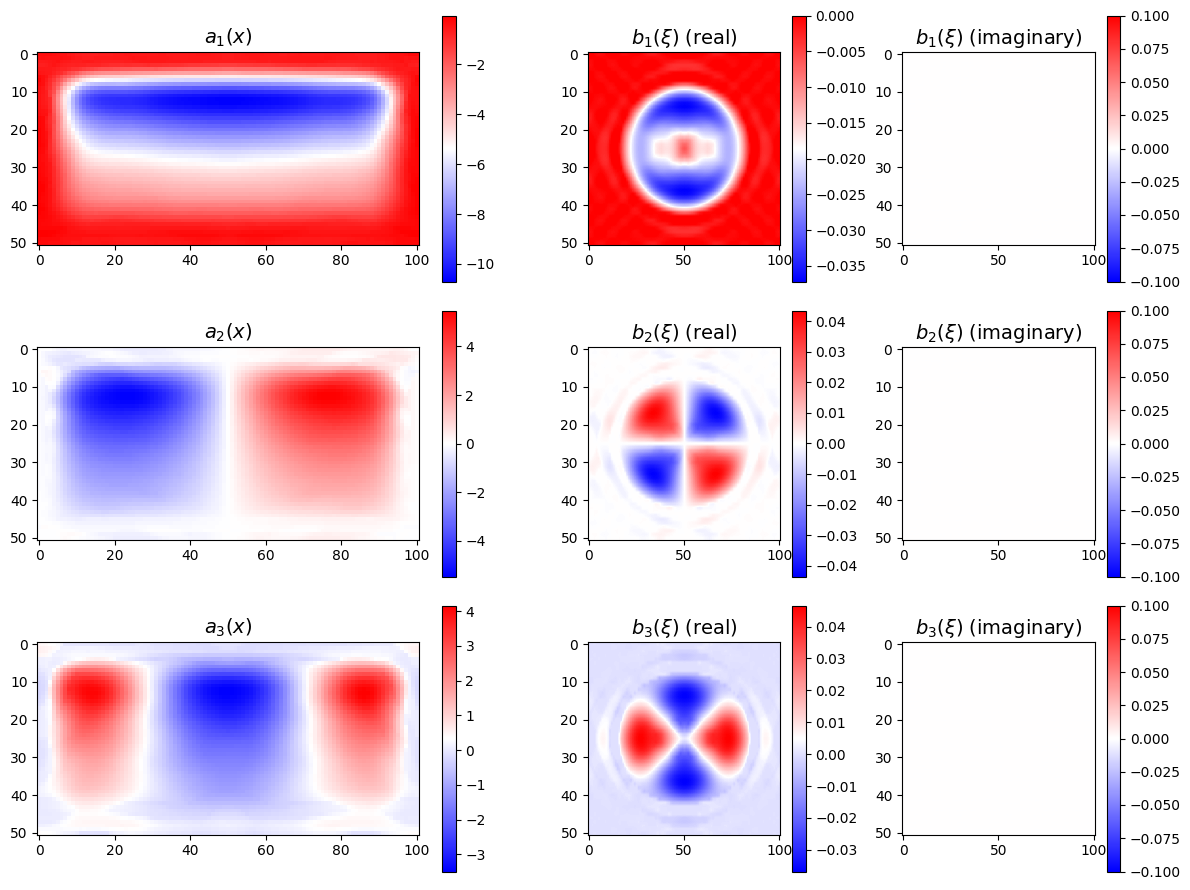

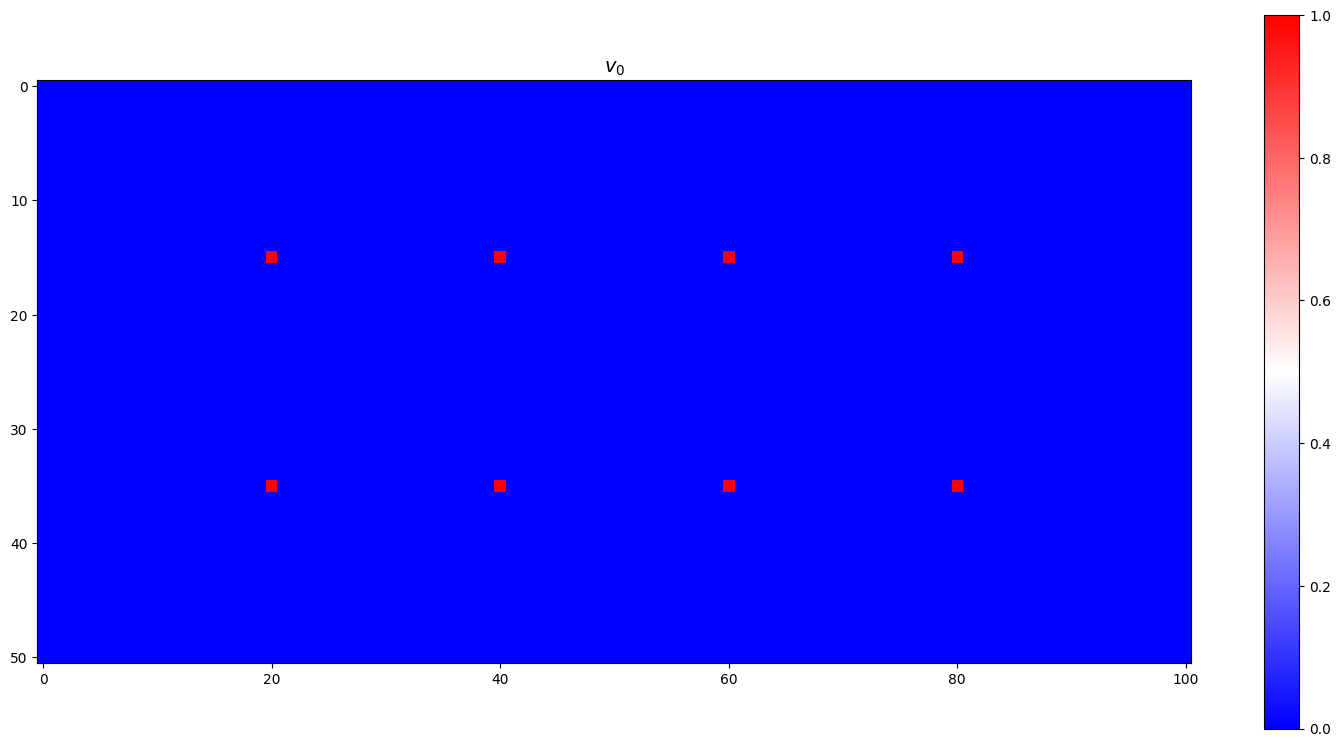

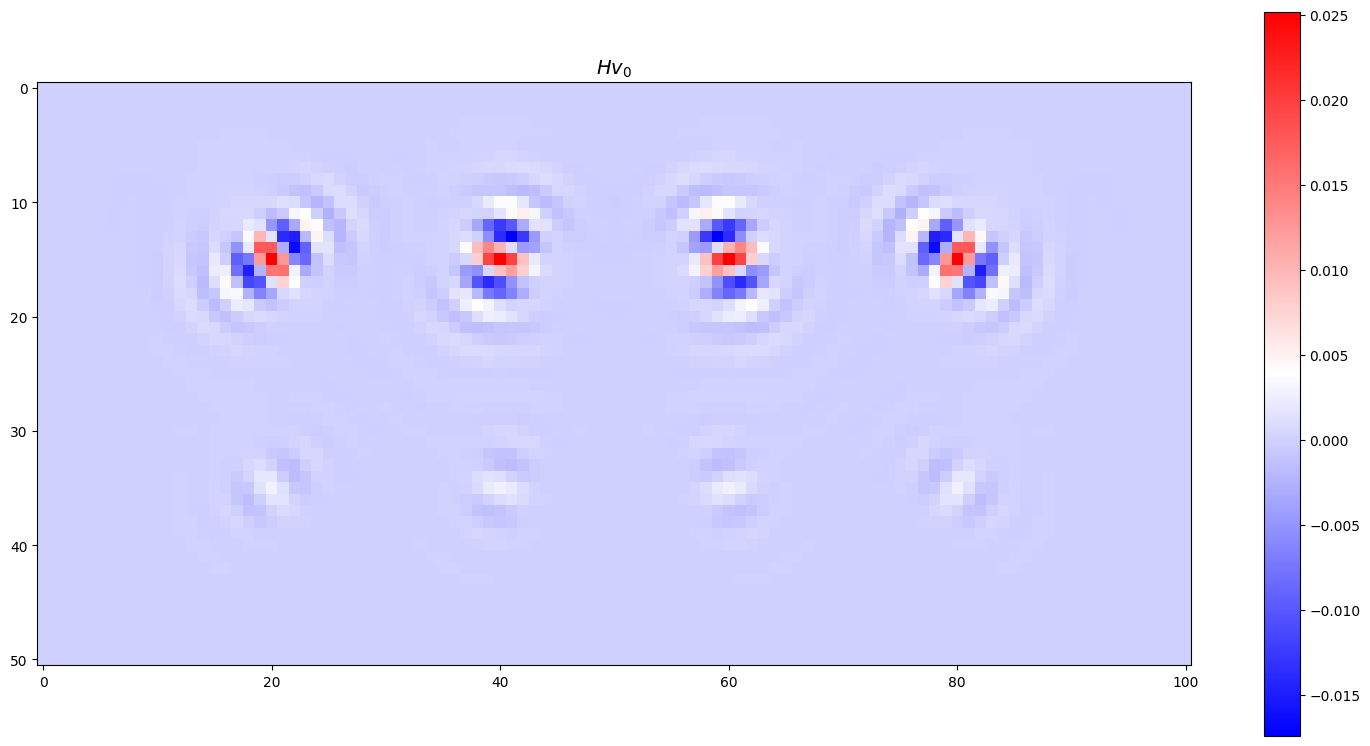

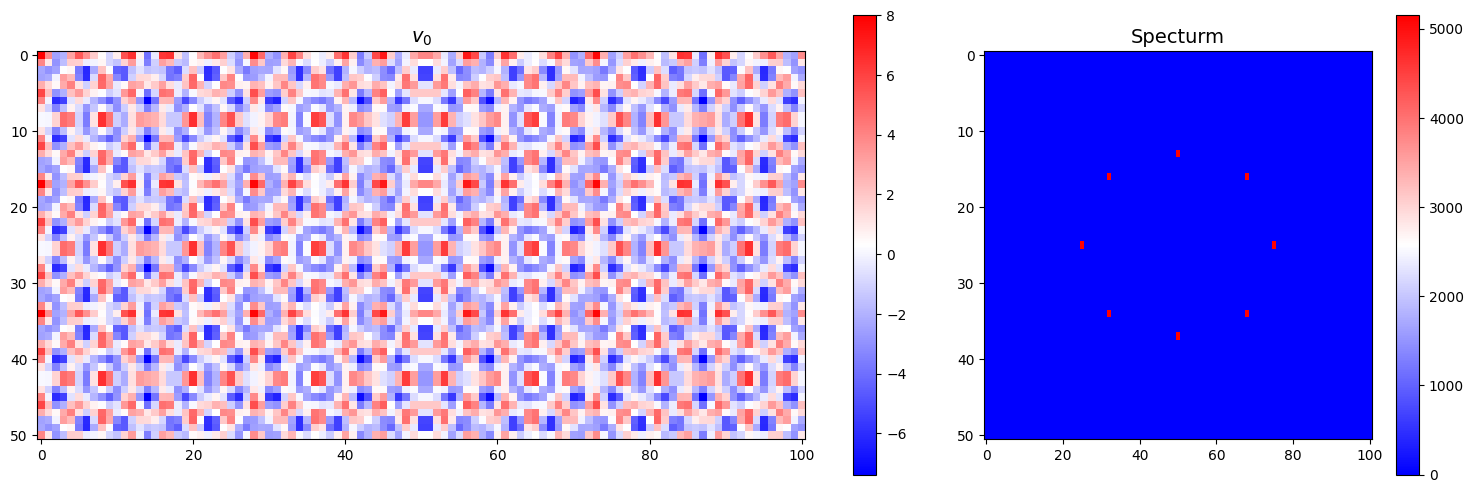

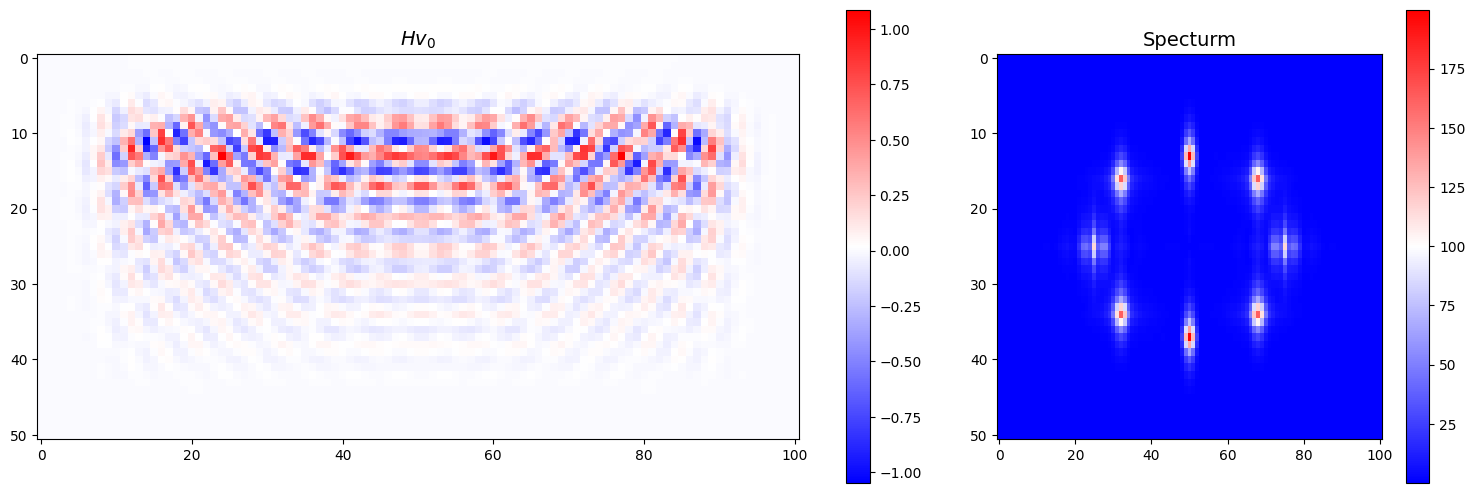

In [6]:
from lrs_psido.approximators import PsfPlusApproximator

psfp_settings = {
    "filter_sigma": 4.0,
    "matvec_plan_rows": [
        {
            "sampling": {
                "method": "equispace",
                "steps": [20, 20],
                "anchor": [20, 15],
                "constraint": {"x": [15, 85]},
                "smoothness": 0.4,
            }
        }
    ],
    "matvec_plan_cols": [
        {
            "sampling": {"method": "circle", "l2_ratio": 0.5, "num_angles": 8},
            "spliting": {
                "method": "ellipse",
                "sigmas": [
                    [8, 6],
                    [8, 8],
                    [12, 12],
                    [8, 8],
                    [8, 6],
                    [8, 8],
                    [12, 12],
                    [8, 8],
                ],
                "smoothness": 0.4,
            },
        }
    ],
    "smooth_rows": False,
    "smooth_cols": False,
    "real_only": True,
    "sqrt": True,
    "rescale": False,
    "symbol_rank": 3,
}
psfp_approximator = PsfPlusApproximator(
    sip.n,
    log_dir=EXP_PATH / "psfp",
    window=sip.window,
    show_proc=False,
    **psfp_settings
)
psfp_sqrtH = psfp_approximator.approximate_sqrt(H)

## Seismic Inversion: Preconditioned L-BFGS

In [7]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as scila
import scipy.sparse.linalg as spla
from inversion.clean import clean_map
from inversion.plbfgs import plbfgs
from psido.linear_operators import RealPDOLowRankSymbol
from utils.fwi_results_analyzer import FWIResultsAnalyzer, get_optim_result
from typing import Sequence
from scipy import ndimage


def get_low_freq_pdo(n: Sequence[int], sigma: float) -> RealPDOLowRankSymbol:
    pdo_c = np.asarray([np.ones(n)])
    pdo_r = np.asarray([ndimage.fourier_gaussian(np.ones(n), sigma=sigma)])
    A = RealPDOLowRankSymbol(pdo_c, pdo_r)
    return A


def run_lbfgs(
    sip: SeismicInverseProblem,
    preconditioning: str,
    sqrtH: spla.LinearOperator,
    low_freq_weight: float,
    low_freq_sigma: float,
    out_path: Path,
) -> None:
    out_path.mkdir(parents=True, exist_ok=True)

    x0 = np.zeros_like(sip.mt)
    if preconditioning == None:  # No preconditioner
        res = plbfgs(
            sip.total_cost,
            sip.total_grad,
            x0,
            max_vector_pairs_stored=100,
            rtol=1e-6,
            stag_tol=1e-12,
            max_iter=500,
            checkpoint_dir=str(out_path),
        )
    elif preconditioning == "prior":  # Prior preconditioner
        res = plbfgs(
            sip.total_cost,
            sip.total_grad,
            x0,
            max_vector_pairs_stored=100,
            rtol=1e-6,
            stag_tol=1e-12,
            max_iter=500,
            checkpoint_dir=str(out_path),
            inv_hess0=sip.Rinv,
            hess0=sip.R,
            lbfgs_inv_hess_kwargs={"gamma_type": 1},
        )
    else:  # Our proposed form of preconditioner
        # Compute dense matrix for small problems
        if low_freq_weight != 0:
            sqrtH = sqrtH + low_freq_weight * get_low_freq_pdo(sip.n, low_freq_sigma)
        Hhat = sqrtH @ sqrtH.H
        Hhat_arr = Hhat @ np.eye(sip.N)
        R_arr = sip.R @ np.eye(sip.N)
        P_arr = scila.inv(Hhat_arr + R_arr)
        P = spla.aslinearoperator(P_arr)
        Pinv = spla.aslinearoperator(Hhat_arr + R_arr)

        res = plbfgs(
            sip.total_cost,
            sip.total_grad,
            x0,
            max_vector_pairs_stored=100,
            rtol=1e-6,
            stag_tol=1e-12,
            max_iter=500,
            checkpoint_dir=str(out_path),
            inv_hess0=P,
            hess0=Pinv,
            lbfgs_inv_hess_kwargs={"gamma_type": 1},
        )

    # Save solution
    xf, info, _ = res
    np.save(out_path / "xf", xf)
    with open(out_path / "info.json", "w") as file:
        json.dump(info, file)

    plt.figure(figsize=sip.x_size)
    sip.plot(sip.m0 + sip.W * xf)
    plt.colorbar()
    plt.title("MAP point")
    plt.savefig(out_path / "mf.png")

    clean_map(out_path)

### No Preconditioner

Iter   1: f = 3.714e+00, |g| = 9.283e-01, |g|/|g0| = 1.000e+00
Iter   2: f = 2.925e+00, |g| = 7.731e-01, |g|/|g0| = 8.328e-01
Iter   3: f = 6.760e-01, |g| = 2.375e-01, |g|/|g0| = 2.559e-01
Iter   4: f = 4.810e-01, |g| = 2.526e-01, |g|/|g0| = 2.721e-01
Iter   5: f = 3.389e-01, |g| = 1.398e-01, |g|/|g0| = 1.506e-01
Iter   6: f = 2.438e-01, |g| = 8.645e-02, |g|/|g0| = 9.313e-02
Iter   7: f = 1.958e-01, |g| = 7.845e-02, |g|/|g0| = 8.451e-02
Iter   8: f = 1.411e-01, |g| = 8.248e-02, |g|/|g0| = 8.885e-02
Iter   9: f = 1.161e-01, |g| = 6.180e-02, |g|/|g0| = 6.657e-02
Iter  10: f = 1.022e-01, |g| = 3.924e-02, |g|/|g0| = 4.227e-02
Iter  11: f = 8.785e-02, |g| = 3.176e-02, |g|/|g0| = 3.421e-02
Iter  12: f = 7.788e-02, |g| = 3.435e-02, |g|/|g0| = 3.701e-02
Iter  13: f = 7.102e-02, |g| = 4.593e-02, |g|/|g0| = 4.948e-02
Iter  14: f = 6.462e-02, |g| = 1.960e-02, |g|/|g0| = 2.112e-02
Iter  15: f = 6.171e-02, |g| = 1.846e-02, |g|/|g0| = 1.988e-02
Iter  16: f = 5.758e-02, |g| = 2.034e-02, |g|/|g0| = 2.

Iter  40: f = 4.171e-02, |g| = 2.217e-03, |g|/|g0| = 2.388e-03
Iter  41: f = 4.168e-02, |g| = 1.581e-03, |g|/|g0| = 1.703e-03
Iter  42: f = 4.164e-02, |g| = 1.897e-03, |g|/|g0| = 2.044e-03
Iter  43: f = 4.161e-02, |g| = 3.032e-03, |g|/|g0| = 3.266e-03
Iter  44: f = 4.157e-02, |g| = 1.841e-03, |g|/|g0| = 1.983e-03
Iter  45: f = 4.154e-02, |g| = 1.340e-03, |g|/|g0| = 1.443e-03
Iter  46: f = 4.152e-02, |g| = 2.013e-03, |g|/|g0| = 2.168e-03
Iter  47: f = 4.150e-02, |g| = 1.945e-03, |g|/|g0| = 2.095e-03
Iter  48: f = 4.148e-02, |g| = 1.455e-03, |g|/|g0| = 1.568e-03
Iter  49: f = 4.145e-02, |g| = 1.084e-03, |g|/|g0| = 1.168e-03
Iter  50: f = 4.144e-02, |g| = 1.645e-03, |g|/|g0| = 1.772e-03
Iter  51: f = 4.143e-02, |g| = 1.098e-03, |g|/|g0| = 1.183e-03
Iter  52: f = 4.141e-02, |g| = 8.283e-04, |g|/|g0| = 8.923e-04
Iter  53: f = 4.141e-02, |g| = 1.460e-03, |g|/|g0| = 1.572e-03
Iter  54: f = 4.140e-02, |g| = 8.549e-04, |g|/|g0| = 9.209e-04
Iter  55: f = 4.139e-02, |g| = 6.809e-04, |g|/|g0| = 7.

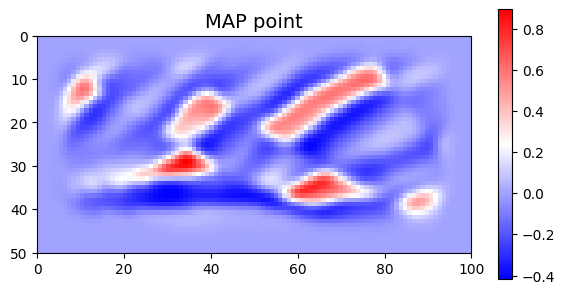

In [8]:
run_lbfgs(sip, None, None, None, None, EXP_PATH / "no_precond/lbfgs")

### Prior Preconditioner

Iter 1: Start using preconditioner
Iter   1: f = 3.714e+00, |g| = 9.283e-01, |g|/|g0| = 1.000e+00
Iter   2: f = 1.487e+00, |g| = 5.080e-01, |g|/|g0| = 5.472e-01
Iter   3: f = 8.379e-01, |g| = 3.061e-01, |g|/|g0| = 3.297e-01
Iter   4: f = 5.194e-01, |g| = 2.192e-01, |g|/|g0| = 2.361e-01
Iter   5: f = 4.017e-01, |g| = 2.359e-01, |g|/|g0| = 2.541e-01
Iter   6: f = 3.069e-01, |g| = 1.186e-01, |g|/|g0| = 1.278e-01
Iter   7: f = 2.502e-01, |g| = 9.856e-02, |g|/|g0| = 1.062e-01
Iter   8: f = 1.975e-01, |g| = 9.091e-02, |g|/|g0| = 9.794e-02
Iter   9: f = 1.454e-01, |g| = 8.913e-02, |g|/|g0| = 9.602e-02
Iter  10: f = 1.206e-01, |g| = 7.254e-02, |g|/|g0| = 7.814e-02
Iter  11: f = 1.031e-01, |g| = 4.819e-02, |g|/|g0| = 5.191e-02
Iter  12: f = 8.957e-02, |g| = 4.681e-02, |g|/|g0| = 5.042e-02
Iter  13: f = 7.912e-02, |g| = 5.151e-02, |g|/|g0| = 5.549e-02
Iter  14: f = 7.059e-02, |g| = 4.593e-02, |g|/|g0| = 4.947e-02
Iter  15: f = 6.441e-02, |g| = 2.921e-02, |g|/|g0| = 3.146e-02
Iter  16: f = 6.022e

Iter  45: f = 4.136e-02, |g| = 1.586e-03, |g|/|g0| = 1.708e-03
Iter  46: f = 4.135e-02, |g| = 7.412e-04, |g|/|g0| = 7.984e-04
Iter  47: f = 4.135e-02, |g| = 4.663e-04, |g|/|g0| = 5.024e-04
Iter  48: f = 4.135e-02, |g| = 3.964e-04, |g|/|g0| = 4.270e-04
Iter  49: f = 4.135e-02, |g| = 9.224e-04, |g|/|g0| = 9.936e-04
Iter  50: f = 4.135e-02, |g| = 4.756e-04, |g|/|g0| = 5.123e-04
Iter  51: f = 4.135e-02, |g| = 3.270e-04, |g|/|g0| = 3.522e-04
Iter  52: f = 4.135e-02, |g| = 3.209e-04, |g|/|g0| = 3.457e-04
Iter  53: f = 4.135e-02, |g| = 4.450e-04, |g|/|g0| = 4.794e-04
Iter  54: f = 4.134e-02, |g| = 3.893e-04, |g|/|g0| = 4.194e-04
Iter  55: f = 4.134e-02, |g| = 2.443e-04, |g|/|g0| = 2.631e-04
Iter  56: f = 4.134e-02, |g| = 2.152e-04, |g|/|g0| = 2.318e-04
Iter  57: f = 4.134e-02, |g| = 2.165e-04, |g|/|g0| = 2.332e-04
Iter  58: f = 4.134e-02, |g| = 2.559e-04, |g|/|g0| = 2.757e-04
Iter  59: f = 4.134e-02, |g| = 1.630e-04, |g|/|g0| = 1.755e-04
Iter  60: f = 4.134e-02, |g| = 1.704e-04, |g|/|g0| = 1.

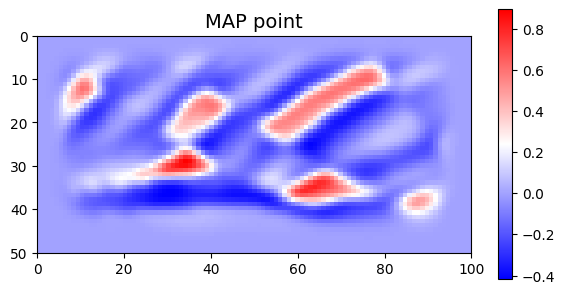

In [9]:
run_lbfgs(sip, "prior", None, None, None, EXP_PATH / "prior_precond/lbfgs")

### PSF Preconditioner

Iter 1: Start using preconditioner
Iter   1: f = 3.714e+00, |g| = 9.283e-01, |g|/|g0| = 1.000e+00
Iter   2: f = 1.832e+00, |g| = 5.615e-01, |g|/|g0| = 6.049e-01
Iter   3: f = 1.189e+00, |g| = 4.111e-01, |g|/|g0| = 4.428e-01
Iter   4: f = 4.447e-01, |g| = 2.572e-01, |g|/|g0| = 2.770e-01
Iter   5: f = 2.718e-01, |g| = 2.244e-01, |g|/|g0| = 2.417e-01
Iter   6: f = 1.646e-01, |g| = 9.516e-02, |g|/|g0| = 1.025e-01
Iter   7: f = 1.331e-01, |g| = 7.664e-02, |g|/|g0| = 8.256e-02
Iter   8: f = 8.668e-02, |g| = 5.787e-02, |g|/|g0| = 6.234e-02
Iter   9: f = 8.395e-02, |g| = 1.126e-01, |g|/|g0| = 1.213e-01
Iter  10: f = 5.938e-02, |g| = 2.929e-02, |g|/|g0| = 3.155e-02
Iter  11: f = 5.725e-02, |g| = 2.053e-02, |g|/|g0| = 2.211e-02
Iter  12: f = 5.326e-02, |g| = 1.670e-02, |g|/|g0| = 1.799e-02
Iter  13: f = 5.077e-02, |g| = 3.254e-02, |g|/|g0| = 3.505e-02
Iter  14: f = 4.798e-02, |g| = 1.697e-02, |g|/|g0| = 1.828e-02
Iter  15: f = 4.712e-02, |g| = 1.175e-02, |g|/|g0| = 1.266e-02
Iter  16: f = 4.546e

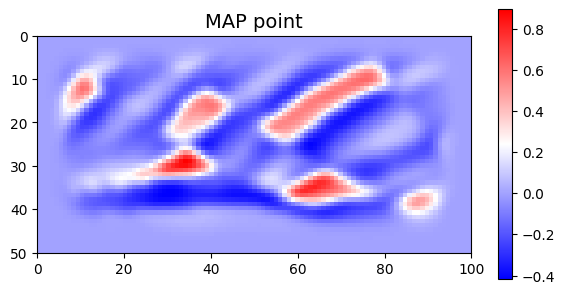

In [10]:
run_lbfgs(sip, "psf", psf_sqrtH, 0.1, 4.0, EXP_PATH / "psf/lbfgs")

### PDO Preconditioner

Iter 1: Start using preconditioner
Iter   1: f = 3.714e+00, |g| = 9.283e-01, |g|/|g0| = 1.000e+00
Iter   2: f = 2.336e+00, |g| = 6.368e-01, |g|/|g0| = 6.860e-01
Iter   3: f = 1.807e+00, |g| = 5.160e-01, |g|/|g0| = 5.559e-01
Iter   4: f = 1.022e+00, |g| = 4.015e-01, |g|/|g0| = 4.325e-01
Iter   5: f = 6.252e-01, |g| = 4.404e-01, |g|/|g0| = 4.744e-01
Iter   6: f = 2.106e-01, |g| = 1.832e-01, |g|/|g0| = 1.973e-01
Iter   7: f = 1.084e-01, |g| = 9.126e-02, |g|/|g0| = 9.831e-02
Iter   8: f = 1.025e-01, |g| = 1.001e-01, |g|/|g0| = 1.078e-01
Iter   9: f = 8.162e-02, |g| = 4.662e-02, |g|/|g0| = 5.022e-02
Iter  10: f = 7.458e-02, |g| = 3.782e-02, |g|/|g0| = 4.074e-02
Iter  11: f = 5.555e-02, |g| = 2.399e-02, |g|/|g0| = 2.584e-02
Iter  12: f = 5.424e-02, |g| = 4.927e-02, |g|/|g0| = 5.308e-02
Iter  13: f = 4.886e-02, |g| = 1.697e-02, |g|/|g0| = 1.828e-02
Iter  14: f = 4.765e-02, |g| = 1.136e-02, |g|/|g0| = 1.224e-02
Iter  15: f = 4.612e-02, |g| = 1.150e-02, |g|/|g0| = 1.238e-02
Iter  16: f = 4.501e

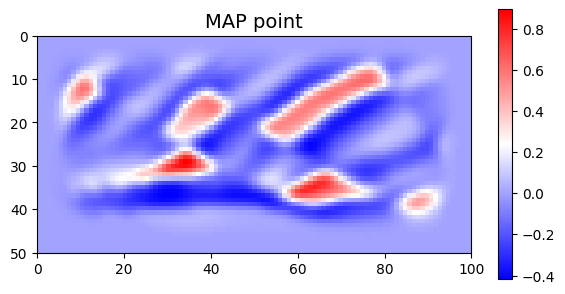

In [11]:
run_lbfgs(sip, "pdo", pdo_sqrtH, 0.1, 4.0, EXP_PATH / "pdo/lbfgs")

### PSF+ Preconditioner

Iter 1: Start using preconditioner
Iter   1: f = 3.714e+00, |g| = 9.283e-01, |g|/|g0| = 1.000e+00
Iter   2: f = 1.948e+00, |g| = 5.748e-01, |g|/|g0| = 6.192e-01
Iter   3: f = 1.342e+00, |g| = 4.481e-01, |g|/|g0| = 4.827e-01
Iter   4: f = 4.802e-01, |g| = 2.903e-01, |g|/|g0| = 3.127e-01
Iter   5: f = 2.666e-01, |g| = 2.681e-01, |g|/|g0| = 2.888e-01
Iter   6: f = 1.156e-01, |g| = 7.366e-02, |g|/|g0| = 7.935e-02
Iter   7: f = 9.472e-02, |g| = 5.297e-02, |g|/|g0| = 5.706e-02
Iter   8: f = 7.173e-02, |g| = 4.421e-02, |g|/|g0| = 4.762e-02
Iter   9: f = 6.863e-02, |g| = 8.796e-02, |g|/|g0| = 9.476e-02
Iter  10: f = 5.340e-02, |g| = 2.148e-02, |g|/|g0| = 2.314e-02
Iter  11: f = 5.190e-02, |g| = 1.383e-02, |g|/|g0| = 1.490e-02
Iter  12: f = 5.027e-02, |g| = 1.499e-02, |g|/|g0| = 1.615e-02
Iter  13: f = 4.817e-02, |g| = 1.617e-02, |g|/|g0| = 1.742e-02
Iter  14: f = 4.550e-02, |g| = 1.260e-02, |g|/|g0| = 1.357e-02
Iter  15: f = 4.468e-02, |g| = 1.472e-02, |g|/|g0| = 1.585e-02
Iter  16: f = 4.367e

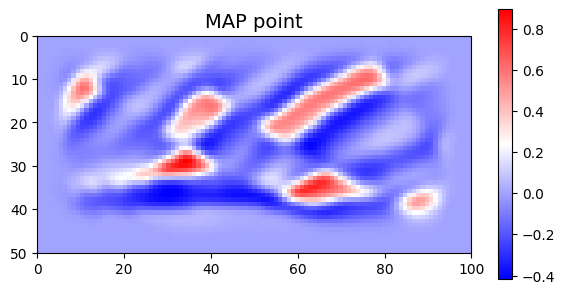

In [12]:
run_lbfgs(sip, "psfp", psfp_sqrtH, 0.1, 4.0, EXP_PATH / "psfp/lbfgs")

### Summary

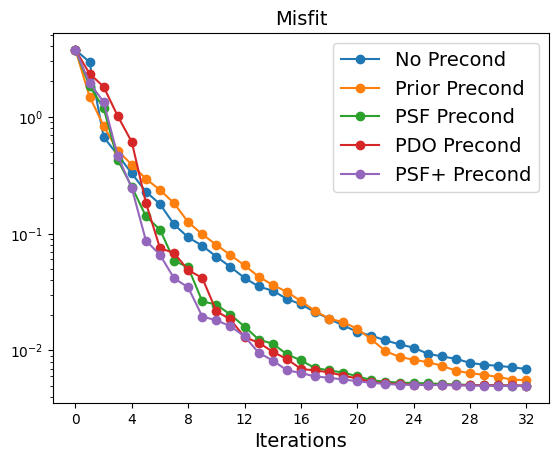

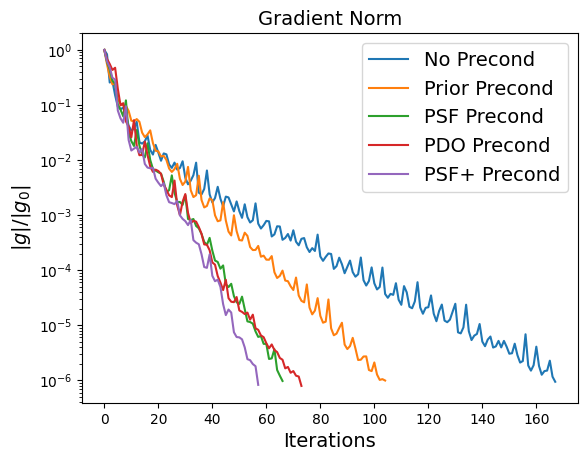

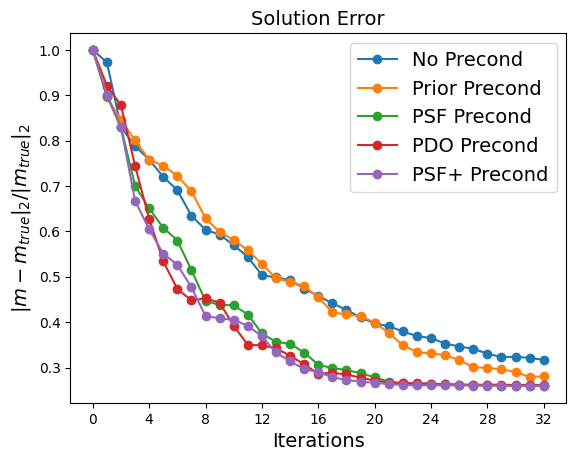

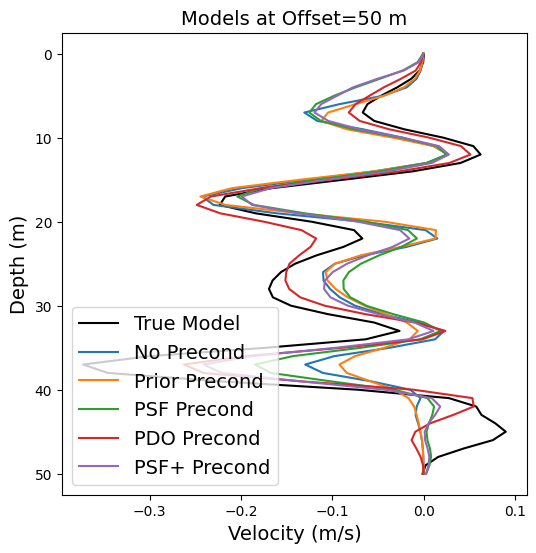

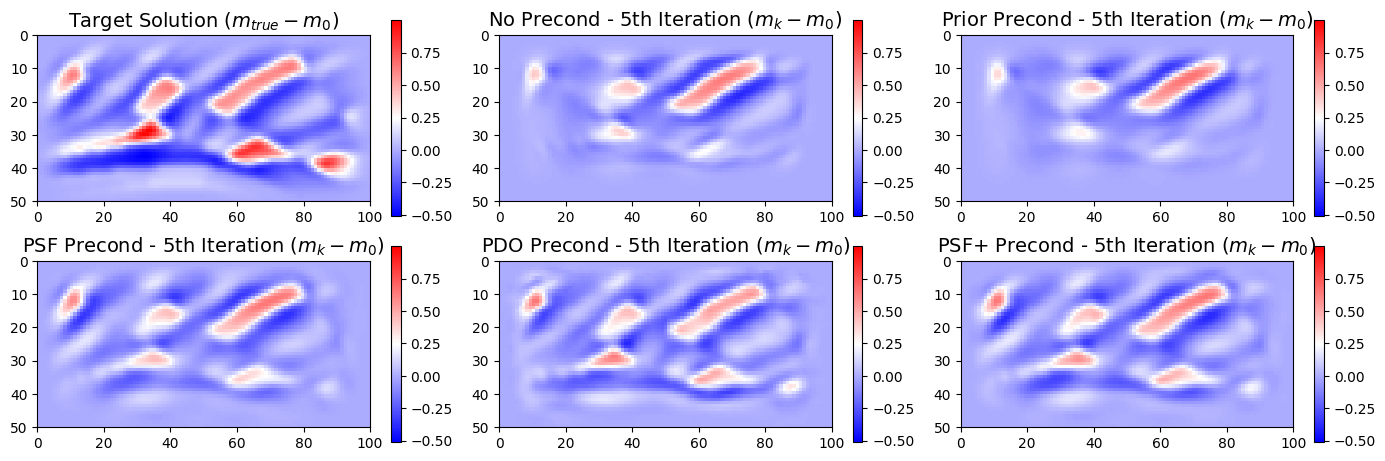

In [13]:
labels = [
    "No Precond",
    "Prior Precond",
    "PSF Precond",
    "PDO Precond",
    "PSF+ Precond",
]
paths = [
    EXP_PATH / "no_precond/lbfgs",
    EXP_PATH / "prior_precond/lbfgs",
    EXP_PATH / "psf/lbfgs",
    EXP_PATH / "pdo/lbfgs",
    EXP_PATH / "psfp/lbfgs",
]
results = [get_optim_result(p, label) for p, label in zip(paths, labels)]
analyzer = FWIResultsAnalyzer(sip, results, output_dir=EXP_PATH / "lbfgs")
analyzer.plot_all(maxiter=32, show_iter=5)

## Uncertainty Quantification: MCMC with gpCN

In [14]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
import scipy.sparse.linalg as spla
from uq.mcmc import MCMC, FullTracer, GaussianPrior, pCNKernel, gpCNKernel
from utils.lowrank import LowRankOperator, LowRankSqrtInvOperator


def run_pcn(
    sip: SeismicInverseProblem, nsamples: int, update_rate: float, out_path: Path
) -> None:
    out_path.mkdir(parents=True, exist_ok=True)

    # Load the MAP point
    xf = np.load(EXP_PATH / "no_precond/lbfgs/xf.npy")

    # prior
    nu = GaussianPrior(
        R=sip.prior.R,
        sqrtRinv=sip.sqrtRinv,
        mean=sip.prior.mean,
    )

    # Set up MCMC
    tracer = FullTracer(nsamples, sip.N, 1000, out_path)
    kernel = pCNKernel(sip.misfit_cost, nu, s=update_rate)
    chain = MCMC(kernel, nsamples, ncheck=100)

    # Draw samples
    np.random.seed(42)  # Reproducible
    naccept = chain.run(xf, tracer=tracer)
    print(f"number of acceptance = {naccept}/{nsamples}", flush=True)

    with open(out_path / "info.txt", "w") as file:
        file.write(f"number of acceptance = {naccept}/{nsamples}")


def run_gpcn(
    sip: SeismicInverseProblem,
    sqrtH: spla.LinearOperator,
    rank: int,
    nsamples: int,
    update_rate: float,
    out_path: Path,
) -> None:
    out_path = Path(out_path)
    out_path.mkdir(parents=True, exist_ok=True)

    xf = np.load(EXP_PATH / "no_precond/lbfgs/xf.npy")
    H = sip.misfit_hess(xf)

    if sqrtH is None:
        Hhat = np.zeros((sip.N, sip.N))
    else:
        Hhat = sqrtH @ sqrtH.H

    H_arr = H @ np.eye(sip.N)
    Hhat_arr = Hhat @ np.eye(sip.N)
    R_arr = sip.R @ np.eye(sip.N)
    HhatR_arr = Hhat_arr + R_arr
    e, V = la.eigh(HhatR_arr)
    sqrtHhatRinv_arr = V @ np.diag(e ** (-0.5)) @ V.T

    # Low-rank correction
    d, U = la.eigh(H_arr - Hhat_arr, HhatR_arr) # replace by rSVD in large-scale
    sort_perm = np.abs(d).argsort()[::-1][:rank]
    d = d[sort_perm].copy()
    U = U[:, sort_perm].copy()
    print("Leading eigenvalues:", d)
    del H_arr, Hhat_arr, R_arr
    approx_HR = LowRankOperator(d, U, HhatR_arr)
    approx_sqrtHRinv = LowRankSqrtInvOperator(d, U, HhatR_arr, sqrtHhatRinv_arr)

    # Laplace approximation to the posterior
    nu = GaussianPrior(
        R=approx_HR,
        sqrtRinv=approx_sqrtHRinv,
        mean=xf,
    )

    # Set up MCMC
    tracer = FullTracer(nsamples, sip.N, 1000, out_path)
    kernel = gpCNKernel(sip.total_cost, nu, s=update_rate)
    chain = MCMC(kernel, nsamples, ncheck=100)

    # Main run
    np.random.seed(42)  # Reproducible
    naccept = chain.run(xf, tracer=tracer)
    print(f"number of acceptance = {naccept}/{nsamples}", flush=True)

    with open(out_path / "info.txt", "a") as file:
        file.write(f"number of acceptance = {naccept}/{nsamples}")

/storage/mathew/Applications/miniconda3/envs/sc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# don't compute f and g together.
sip = SeismicInverseProblem(label="idealized", path=EXP_PATH, fast_cost=True, **model_config)

Prior: delta = 1.5958e-02, gamma = 1.2467e-02


### Prior Preconditioner (pCN)

In [16]:
# run_pcn(sip, 50000, 0.01, EXP_PATH / "prior_precond/pcn")

### Low-Rank Preconditioner (gpCN-LR)

In [17]:
# run_gpcn(sip, None, 100, 50000, 0.02, EXP_PATH / "prior_precond/gpcn")

### PSF Preconditioner (gpCN-PSF)

In [18]:
# run_gpcn(sip, psf_sqrtH, 100, 50000, 0.1, EXP_PATH / "psf/gpcn")

### PDO Preconditioner (gpCN-PDO)

In [19]:
# run_gpcn(sip, pdo_sqrtH, 100, 50000, 0.06, EXP_PATH / "pdo/gpcn")

### PSF+ Preconditioner (gpCN-PSF+)

In [20]:
# run_gpcn(sip, psfp_sqrtH, 100, 50000, 0.18, EXP_PATH / "psfp/gpcn")

### Summary

In [21]:
from seismic_inversion.mcmc_output_pipeline import MCMCResultsAnalyzer


labels = [
    "pCN",
    "gpCN-LR",
    "gpCN-PSF",
    "gpCN-PDO",
    "gpCN-PSF+",
]
colors = ["tab:red", "tab:green", "tab:purple", "tab:brown", "tab:orange"]
paths = [
    EXP_PATH / "prior_precond/pcn",
    EXP_PATH / "prior_precond/gpcn",
    EXP_PATH / "psf/gpcn",
    EXP_PATH / "pdo/gpcn",
    EXP_PATH / "psfp/gpcn",
]
tracers = [FullTracer(50000, sip.N, 1000, path, True) for path in paths]
datas = [t.data for t in tracers]

qoi_points = np.array([[50, 20], [10, 10], [75, 10], [90, 30], [40, 38]])
output_dir = EXP_PATH / "mcmc"

xf = np.load(EXP_PATH / "no_precond/lbfgs/xf.npy")
HR = sip.total_hess(xf) @ np.eye(sip.N)
HRinv = la.inv(HR)
std = np.sqrt(np.diag(HRinv))

analyzer = MCMCResultsAnalyzer(
    sip,
    datas,
    labels,
    colors,
    qoi_points,
    output_dir,
    true_mean=xf,
    true_std=std,
)

Load 50000 existing samples.
Load 50000 existing samples.
Load 50000 existing samples.
Load 50000 existing samples.
Load 50000 existing samples.


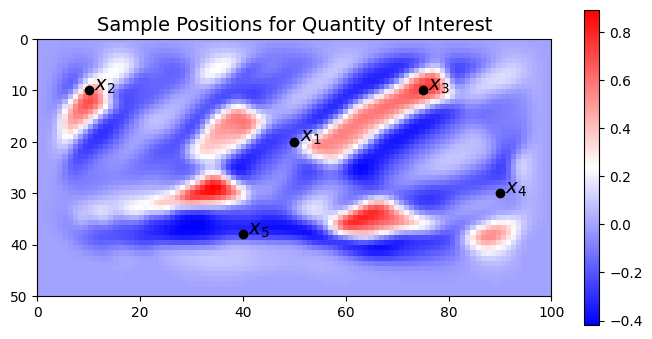

In [22]:
analyzer.plot_qoi_points(xf)

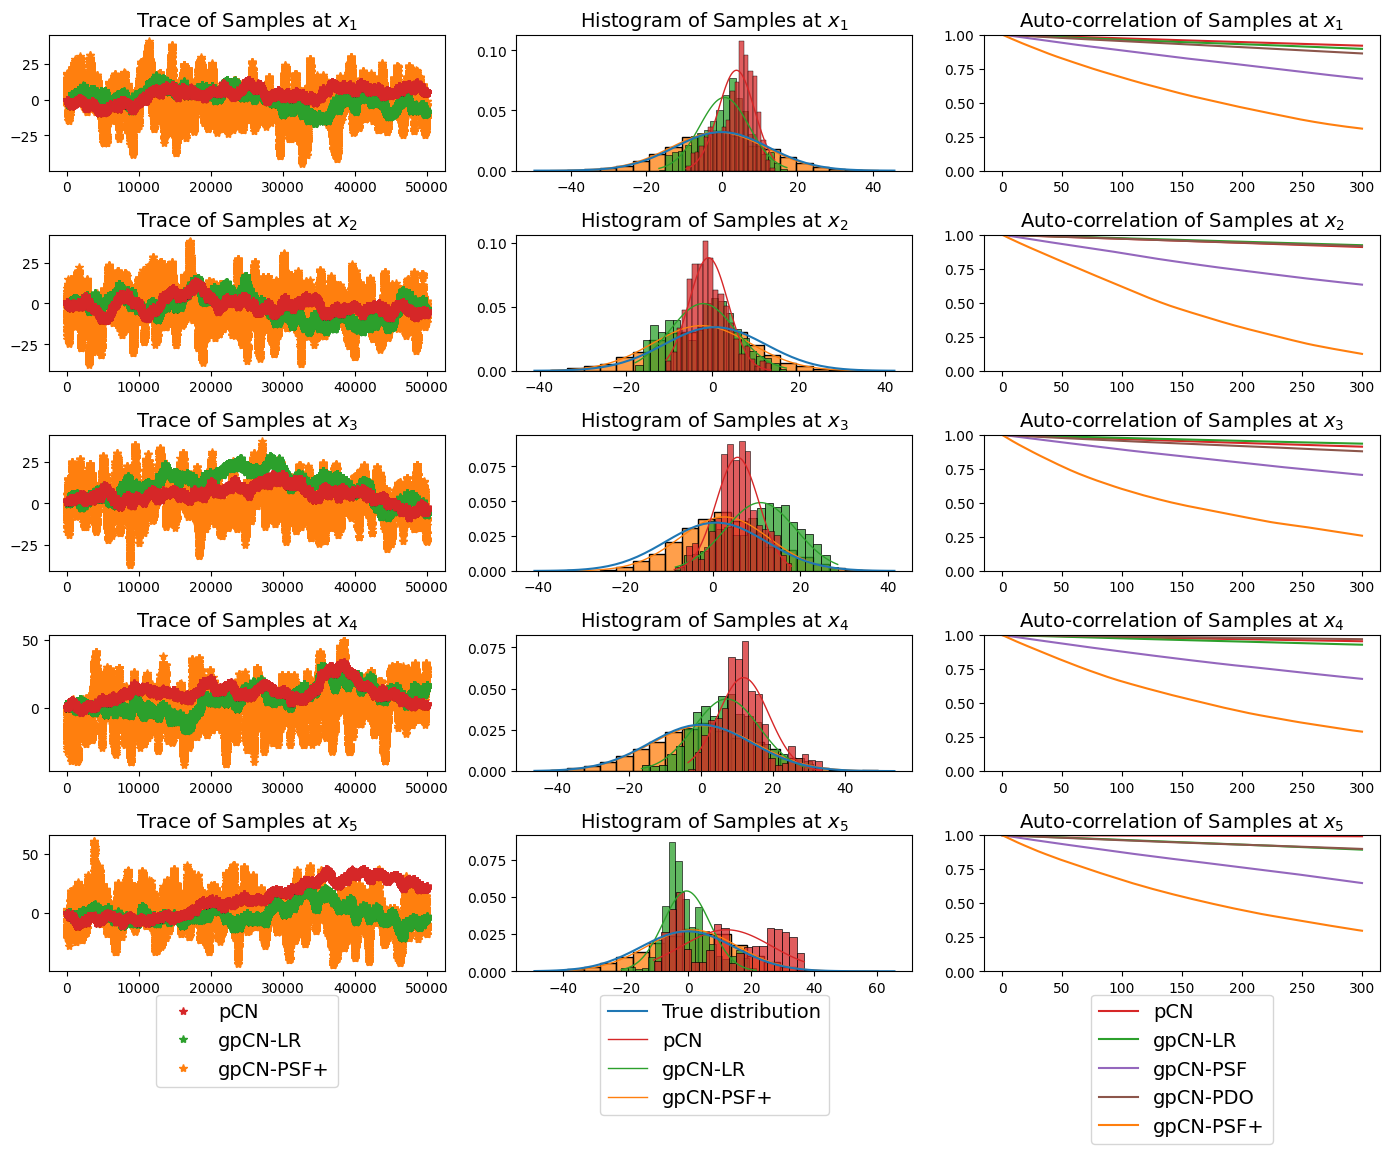

In [23]:
analyzer.plot_trace_hist_acc(selected=[4, 1, 0], max_lag=300)

In [24]:
iat = analyzer.compute_iat(max_lag=3000)
ess = 50000 / iat
print("ESS:\n", ess)

ESS:
 [[ 11.48972169  16.89469995  11.14231547  11.50185053   8.6733427 ]
 [ 11.98103463  11.02333966  10.68391498  10.50706104  12.14288901]
 [ 35.39363448  35.54698586  18.29955813  29.22291819  42.00153934]
 [ 19.52815822  11.62261661  12.11647162   9.37733292  13.72785294]
 [ 97.81486712 130.97779896 130.29019969  86.46421755  97.43802653]]


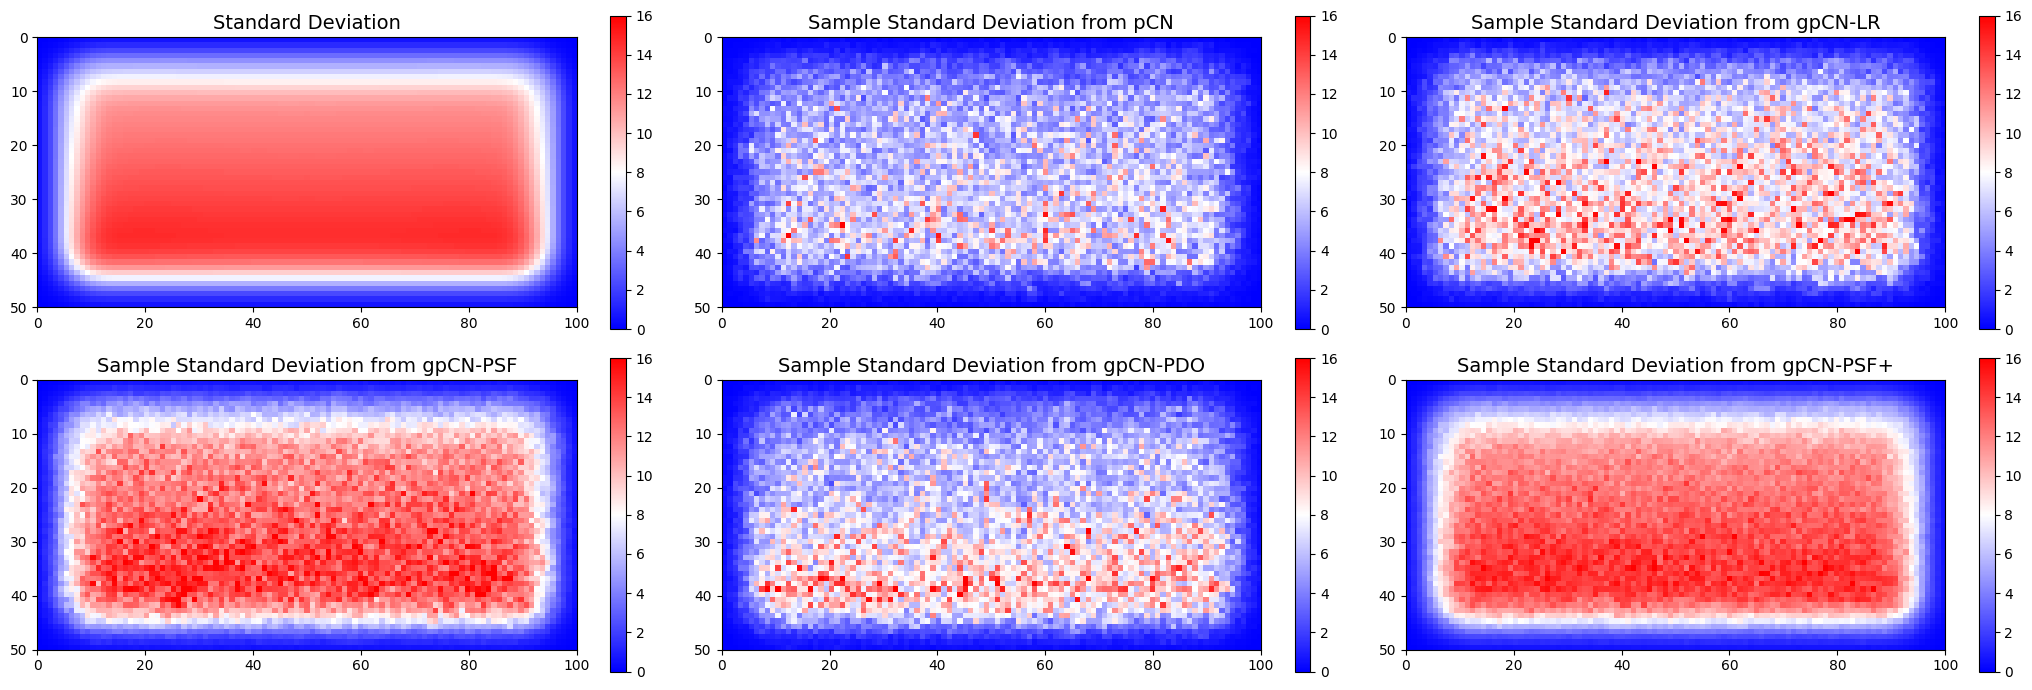

In [25]:
vmin, vmax = 0.0, 16.0
fig, axs = plt.subplots(2, 3, figsize=(sip.x_size * (3, 2)))
plt.sca(axs.flat[0])
sip.plot(
    sip.W @ analyzer.true_std,
    vmin=vmin,
    vmax=vmax,
    title="Standard Deviation",
    colorbar=True,
)
for i in range(analyzer.N):
    plt.sca(axs.flat[i + 1])
    std = np.std(analyzer.datas[i], axis=0, ddof=1)
    sip.plot(
        sip.W @ std,
        vmin=vmin,
        vmax=vmax,
        title="Sample Standard Deviation from " + analyzer.labels[i],
        colorbar=True,
    )
plt.tight_layout()